# Milestone 2 : Project proposal and initial analyses 🍻

<hr style="clear:both">
This notebook was made for the ADA course at EPFL (CS-401). 

Group : BeerADAventure46

**Authors:** \
[Agatha Hunter](https://people.epfl.ch/agatha.hunter)\
[Anne-Valérie Preto](https://people.epfl.ch/anne-valerie.preto)\
[Tristan Carruzzo](https://people.epfl.ch/tristan.carruzzo)\
[Thamin Maurer](https://people.epfl.ch/thamin.maurer)\
[Victor Dubien](https://people.epfl.ch/victor.dubien)


**Supervisor:**\
[Beatriz Borges](https://people.epfl.ch/beatriz.borges)
<hr style="clear:both">



<blockquote>

## Project proposal  📌

**Influence of the serving style on the tasting profile**:

Goal of the project: Use the textual reviews to find for each beer how it was served (either bottle, can or draft) and find how it influences the tasting profile.

Different serving styles may be adopted in different regions or for different types of beer.  The influence of the serving style could influence not only the appearance, but also the aroma, the palate or the taste.
</blockquote>

### Import libraries

In [1]:
from utils import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 40)

## 1. Datasets 📂

### 1.1 Import dataset

In [2]:
## Firt time imports
 
# Convert txt to parquet
#ratings = convert_txt_to_parquet(input_file='ratings.txt', export=True, file_name='ratings')
#reviews = convert_txt_to_parquet(input_file='reviews.txt', export=True, file_name='reviews')

<div class="alert alert-block alert-danger">
<b>Danger:</b> 
Change function to read directly from zip file!
</div>

In [3]:
## Files already converted, so we can load them directly

#reviews = pq.read_table(dataset_path + 'reviews.csv').to_pandas()
reviews = pd.read_csv(dataset_path + 'reviews.csv')
beers = pd.read_csv(dataset_path + 'beers.csv')
breweries = pd.read_csv(dataset_path + 'breweries.csv')
users = pd.read_csv(dataset_path + 'users.csv')

### 1.2 Initial datasets analysis 🔎

#### 1.2.1 Beers dataset 🍺

In [4]:
display(beers.sample(3))
print('Shape of beers : ', beers.shape)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
33735,214381,AbbaziAle,43725,Birrificio Della Granda,Dubbel,1,0,3.75,NaN,NaN,6.5,3.750,-0.487345,0,NaN
228264,168754,Citrapolis,36769,Arclight Brewing Company,American Double / Imperial IPA,5,0,4.18,NaN,NaN,8.3,4.182,NaN,0,NaN
187301,57089,Equinox Brown,1178,Great Waters Brewing,Belgian Dark Ale,1,1,3.68,NaN,NaN,NaN,3.680,NaN,0,NaN


Shape of beers :  (280823, 15)


In [5]:
# print the number of beers id and beer name
print('Number of different beers id:', len(beers.beer_id.unique()))
print('Number of different beers name:', len(beers.beer_name.unique()))

Number of different beers id: 280823
Number of different beers name: 236209


<blockquote>

**Initial comments about the dataset**

-Some beers have the same name! In order to avoid confusion, we will drop the column beer_name (and brewery_name) from the dataset.

-As we will not use the RateBeer dataset, we can also drop the column nbr_matched_valid_ratings and avg_matched_valid_ratings.  

-The column bros_score only reflect the ratings from the two creators of the website, so we can also drop it.  

-ba_score represents the percentage (rounded to the tenth for depth) of raters who gave the beer a 3.75 or higher as long as the beers as at least 10 ratings.

</blockquote>

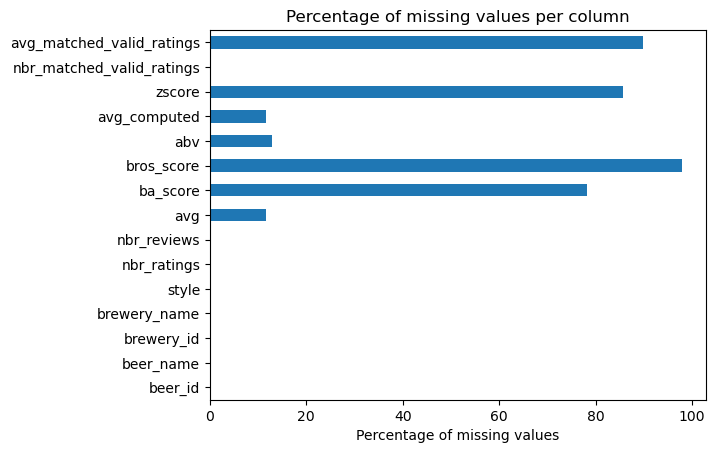

avg                      : 32829 missing values (11.69%)
ba_score                 : 219623 missing values (78.21%)
bros_score               : 275121 missing values (97.97%)
abv                      : 36024 missing values (12.83%)
avg_computed             : 32841 missing values (11.69%)
zscore                   : 240538 missing values (85.65%)
avg_matched_valid_ratings: 252551 missing values (89.93%)


In [6]:
show_missing(beers)

<blockquote>

**More comments about the dataset**

-We see that more than 80% of the beers do not have a z-score value. Since this value takes into account reviews from both websites and is vastly missing, we can drop the column alongside avg_computed. We might compute them manually later if needed.

-80% of the beers have no ba_score value, so we can also drop it and compute it later if needed.

-The other columns with NaN such as avg_matched_valid_ratings, avg_computed or bros_score are not useful in our analysis since we only look at the BeerAdvocate reviews.

-The column abv, which represents the alcohol percentage in a beer, is missing for approximately 12%.

</blockquote>

In [7]:
beers_filtered = beers.drop(columns=['beer_name', 
                            'brewery_name',
                            'bros_score',
                            'ba_score',
                            'nbr_matched_valid_ratings',
                            'avg_matched_valid_ratings',
                            'zscore',
                            'avg_computed']).copy(deep=True)

beers_filtered.rename(columns={'nbr_ratings': 'beer_nbr_ratings',
                               'nbr_reviews': 'beer_nbr_reviews'}, inplace=True)

In [8]:
beers_filtered.sample(3)

,beer_id,brewery_id,style,beer_nbr_ratings,beer_nbr_reviews,avg,abv
97350,8789,147,Belgian Strong Dark Ale,287,195,3.92,8.5
39943,105893,6770,German Pilsener,0,0,NaN,5.1
186791,188624,35306,American Pale Wheat Ale,1,0,3.62,5.2


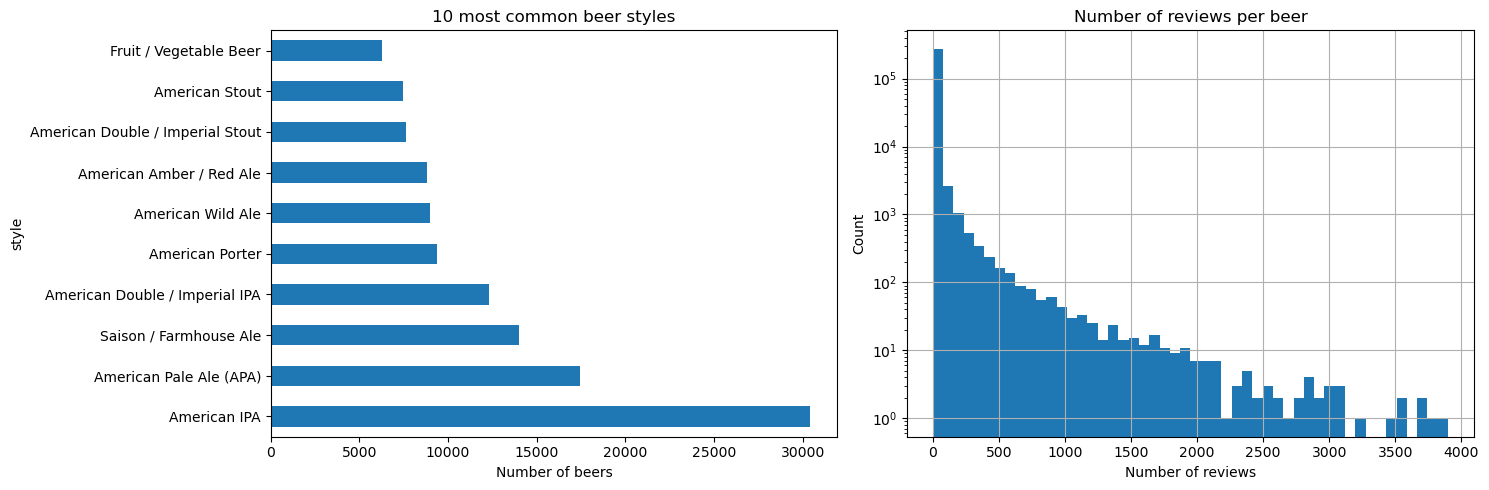

In [9]:
# Representation of the beers dataset
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
beers_filtered['style'].value_counts(normalize=False).head(10).plot(kind='barh', title='10 most common beer styles')
plt.xlabel('Number of beers')
plt.subplot(1, 2, 2)
beers_filtered['beer_nbr_reviews'].hist(bins=50,log=True)
plt.title('Number of reviews per beer')
plt.ylabel('Count')
plt.xlabel('Number of reviews')
plt.tight_layout()
plt.show()

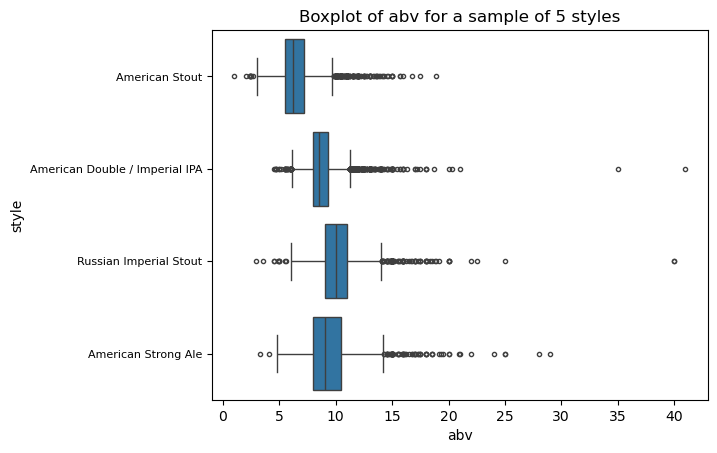

In [10]:
# boxplot of abv for sample of beers 
plt.figure()
sample_styles = beers_filtered['style'].sample(5)  # Select a sample of 5 beer styles
sns.boxplot(y='style', x='abv', data=beers_filtered[beers_filtered['style'].isin(sample_styles)], fliersize=3)
plt.yticks(fontsize=8)
plt.title('Boxplot of abv for a sample of 5 styles')
plt.show()

In [11]:
# group the beers by style and compute the median of abv for each style
median_abv_by_style = beers_filtered.groupby('style')['abv'].median()
# display(median_abv_by_style.sample(3))

# fill the missing abv values with the median of abv for the style of each beer
beers_filtered['abv'] = beers_filtered.apply(lambda x: median_abv_by_style[x['style']] if pd.isna(x['abv']) else x['abv'], axis=1)

In [12]:
beers_filtered.describe()

,beer_id,brewery_id,beer_nbr_ratings,beer_nbr_reviews,avg,abv
count,280823.000000,280823.000000,280823.000000,280823.000000,247994.000000,280823.000000
mean,148556.817141,21335.895860,29.887267,9.221417,3.721034,6.434481
std,84307.593397,15385.715656,231.010063,68.866445,0.476003,1.984850
min,3.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,76513.500000,3835.000000,1.000000,0.000000,3.500000,5.000000
50%,148867.000000,24075.000000,2.000000,1.000000,3.780000,6.000000
75%,221817.500000,33960.000000,8.000000,2.000000,4.010000,7.300000
max,293296.000000,49817.000000,16509.000000,3899.000000,5.000000,67.500000


<blockquote>

We are left with a dataset containing 280823 beers. We are only missing some values for avg as some beers do not have any ratings/reviews. They will be removed later when merging with the reviews dataset anyway.

</blockquote>

#### 1.2.2 Breweries dataset 🏭

In [13]:
display(breweries.sample(3))
print('Shape of breweries : ', breweries.shape)

,id,location,name,nbr_beers
2604,3553,Japan,Yo-Ho Brewing Company,39
2692,9482,Japan,Ishikari Banya No Ji-Beer,5
12920,45979,"United States, Ohio",Brausch Brewery,8


Shape of breweries :  (16758, 4)


In [14]:
# show the missing values
show_missing(breweries)

There are no missing values in this dataset.


<blockquote>

This dataset has no missing values, we will simply rename the columns and drop the brewery name.

</blockquote>

In [15]:
breweries_filtered = breweries.drop(columns=['name']).copy(deep=True)

breweries_filtered.rename(columns={'id':'brewery_id',
                                   'location':'brewery_location',
                                   'nbr_beers':'brewery_nbr_beers'}, inplace=True)

In [16]:
display(breweries_filtered.sample(3))
print('Shape of breweries filtered: ', breweries_filtered.shape)

,brewery_id,brewery_location,brewery_nbr_beers
4507,20506,Germany,1
1773,48549,Canada,3
3812,48125,Germany,0


Shape of breweries filtered:  (16758, 3)


In [17]:
# Some breweries have weird location values, they contain google maps links. All the breweries with a weird location value are in the US.
print('Number of breweries with a weird location value:', len(breweries_filtered[breweries_filtered['brewery_location'].str.contains('<', na=False)]))

# for loc in breweries_filtered[breweries_filtered['brewery_location'].str.contains('<', na=False)]['brewery_location'].unique():
#     print(loc) # print the strange values

Number of breweries with a weird location value: 35


In [18]:
# manually adding the location for those 35 breweries

#obtain the brewery_id of the 35 breweries
strange_id = breweries_filtered[breweries_filtered['brewery_location'].str.contains('<', na=False)]['brewery_id'].unique()

# create a dic with the brewery_id as key and unknwon as value
dic = {}
for i in strange_id:
    dic[i] = 'unknown'
    
# function that takes as input the brewery_id and a location and change the location of the brewery with the given id in the dictionary dic 
def change_location(brewery_id, us_state):
    location = 'United States, ' + us_state
    dic[brewery_id] = location

In [19]:
# take the first element of dic that has value unknown and print its location
for key, value in dic.items():
    if value == 'unknown':
        print('Brewery id:', key)
        print('Strange location:',breweries_filtered[breweries_filtered['brewery_id'] == key]['brewery_location'].values[0])        
        break

Brewery id: 2434
Strange location: United States</a> | <a href="http://maps.google.com/maps?oi=map&q=%2C+US" target="_blank">map</a><br><a href="http://bluecorncafe.com" target="_blank">bluecorncafe.com


In [20]:
#Changing the location in dic

change_location(brewery_id=2434,us_state='New Mexico')
change_location(brewery_id=2730,us_state='Wisconsin')
change_location(brewery_id=1551,us_state='California')
change_location(brewery_id=1552,us_state='Michigan')
change_location(brewery_id=2710,us_state='California')
change_location(brewery_id=3681,us_state='Ohio')
change_location(brewery_id=2413,us_state='California')
change_location(brewery_id=1793,us_state='Virginia')
change_location(brewery_id=6045,us_state='New Jersey')
change_location(brewery_id=2776,us_state='New York')
change_location(brewery_id=1751,us_state='Texas')
change_location(brewery_id=1554,us_state='Georgia')
change_location(brewery_id=1961,us_state='Maine')
change_location(brewery_id=4927,us_state='South Carolina')
change_location(brewery_id=23973,us_state='Maine')
change_location(brewery_id=2512,us_state='California')
change_location(brewery_id=6416,us_state='New Jersey')
change_location(brewery_id=2104,us_state='Oregon')
change_location(brewery_id=3079,us_state='Washington')
change_location(brewery_id=2410,us_state='Michigan')
change_location(brewery_id=1931,us_state='Ohio')
change_location(brewery_id=1553,us_state='Maine')
change_location(brewery_id=1550,us_state='Colorado')
change_location(brewery_id=32764,us_state='Illinois')
change_location(brewery_id=8451,us_state='Wyoming')
change_location(brewery_id=5114,us_state='California')
change_location(brewery_id=1802,us_state='North Carolina')
change_location(brewery_id=1819,us_state='Minnesota')
change_location(brewery_id=200,us_state='California')
change_location(brewery_id=918,us_state='Florida')
change_location(brewery_id=4343,us_state='California')
change_location(brewery_id=9765,us_state='New York')
change_location(brewery_id=1927,us_state='Colorado')
change_location(brewery_id=28908,us_state='Utah')
change_location(brewery_id=70,us_state='Oregon')
change_location(brewery_id=1567,us_state='Hawaii')

In [21]:
# change the location of the breweries in the breweries_filtered dataframe
for key, value in dic.items():
    breweries_filtered.loc[breweries_filtered['brewery_id'] == key, 'brewery_location'] = value

In [22]:
# how many different locations are there that contain United States
print('Number of different locations that contain United States:', len(breweries_filtered[breweries_filtered['brewery_location'].str.contains('United States')]['brewery_location'].unique()))

Number of different locations that contain United States: 50


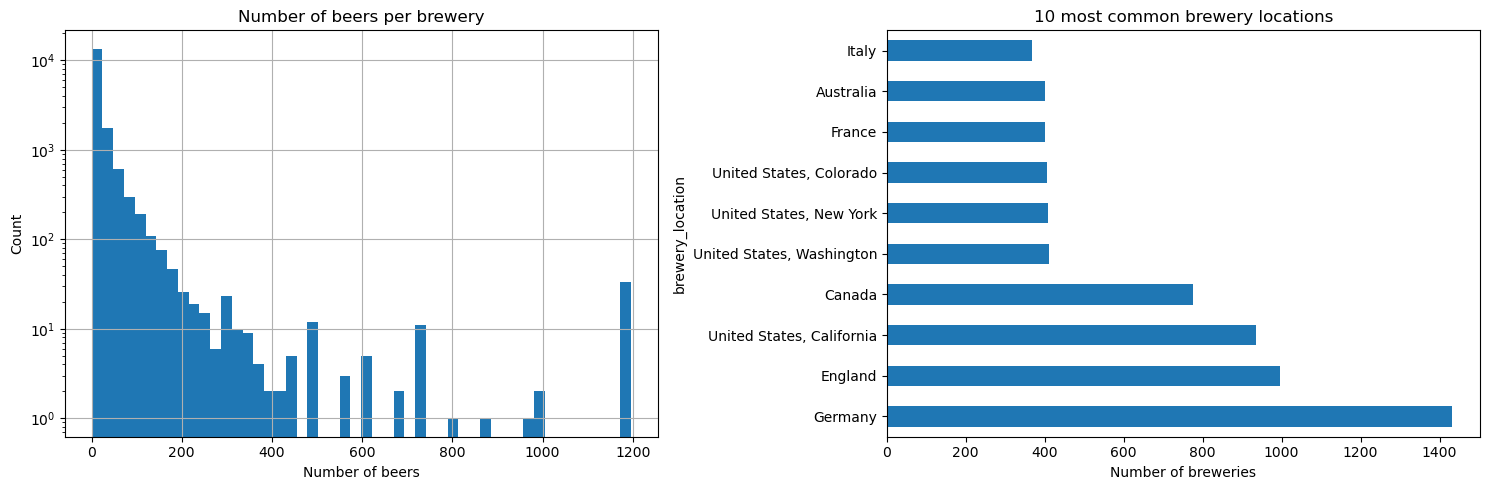

In [23]:
# Representation of beers per brewery and most common brewery locations
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
breweries_filtered['brewery_nbr_beers'].hist(bins=50, log=True)
plt.title('Number of beers per brewery')
plt.ylabel('Count')
plt.xlabel('Number of beers')
plt.subplot(1, 2, 2)
breweries_filtered['brewery_location'].value_counts(normalize=False).head(10).plot(kind='barh', title='10 most common brewery locations')
plt.xlabel('Number of breweries')
plt.tight_layout()
plt.show()

#### 1.2.3 Users dataset 👤

In [24]:
display(users.sample(3))
print('Shape of users : ', users.shape)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
133137,2,0,jman1783.843188,jman1783,1.407665e+09,"United States, North Carolina"
83709,6,6,degrog.61385,DeGrog,1.138014e+09,"United States, California"
87393,5,5,greenkrusty101.273528,GreenKrusty101,1.228388e+09,"United States, Nevada"


Shape of users :  (153704, 6)


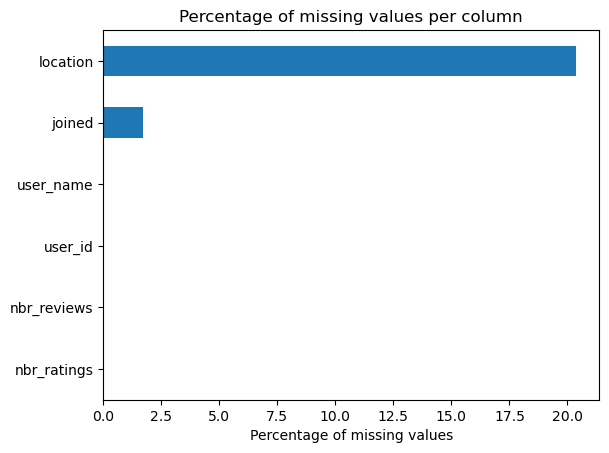

user_name                :     1 missing values (0.00%)
joined                   :  2652 missing values (1.73%)
location                 : 31279 missing values (20.35%)


In [25]:
show_missing(users)

<blockquote>

We are only missing information about when the user joined the website and locations. (and 1 username, which we drop anyway)

</blockquote>

In [26]:
users_filtered = users.drop(columns=['user_name']).copy(deep=True)

users_filtered.rename(columns={'nbr_ratings':'user_nbr_ratings',
                               'nbr_reviews':'user_nbr_reviews',
                               'joined':'user_joined',
                               'location':'user_location'}, inplace=True)

display(users_filtered.sample(3))
print('Shape of users filtered: ', users_filtered.shape)

,user_nbr_ratings,user_nbr_reviews,user_id,user_joined,user_location
12737,128,128,capeannbass36.362667,1.251022e+09,"United States, Massachusetts"
55628,3,0,assarsson.994027,1.433066e+09,Sweden
115302,3,2,docpage.980926,1.430302e+09,"United States, Washington"


Shape of users filtered:  (153704, 5)


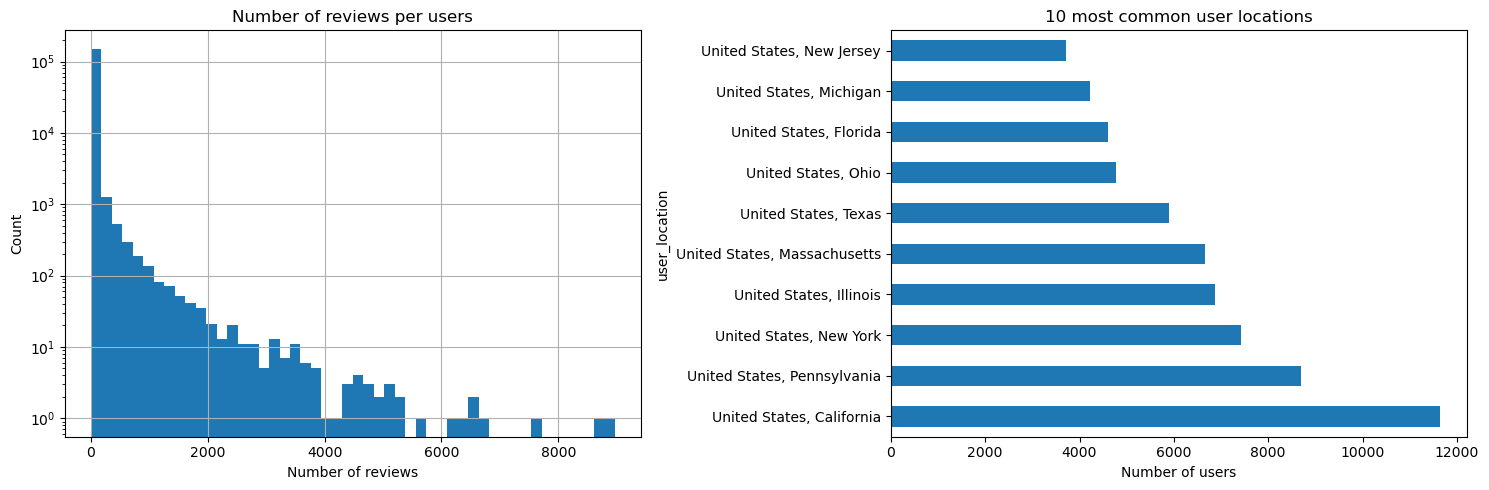

In [27]:
# Representation of reviews per user and most common user locations
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
users_filtered['user_nbr_reviews'].hist(bins=50, log=True)
plt.title('Number of reviews per users')
plt.ylabel('Count')
plt.xlabel('Number of reviews')
plt.subplot(1, 2, 2)
users_filtered['user_location'].value_counts(normalize=False).head(10).plot(kind='barh', title='10 most common user locations')
plt.xlabel('Number of users')
plt.tight_layout()
plt.show()

<blockquote>

We observe that many users have no reviews at all, they will be removed from the dataset when merging. Also, the 10 most common user location are all in the US.

</blockquote>

#### 1.2.4 Reviews dataset 📝

In [28]:
display(reviews.sample(3))
print('Shape of reviews : ', reviews.shape)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
105996,Negra Modelo,667,Grupo Modelo S.A. de C.V.,75,Vienna Lager,5.4,1488279600,andrewh995,andrewh995.1184297,3.5,2.75,3.25,4.0,3.5,3.50,You know I actually really like this beer alot...
309037,Weihenstephaner Hefeweissbier Dunkel,808,Bayerische Staatsbrauerei Weihenstephan,252,Dunkelweizen,5.3,1328007600,WildMaverick1200,wildmaverick1200.316621,4.5,3.50,5.00,4.0,4.5,4.11,Found this at the local market! Let's see what...
999161,Samuel Adams Cranberry Lambic,1903,Boston Beer Company (Samuel Adams),35,Fruit / Vegetable Beer,5.9,1284717600,Plokhooy,plokhooy.499855,3.0,3.00,3.00,2.0,2.0,2.40,"First off, not a true Lambic but more of a fru..."


Shape of reviews :  (2589586, 16)


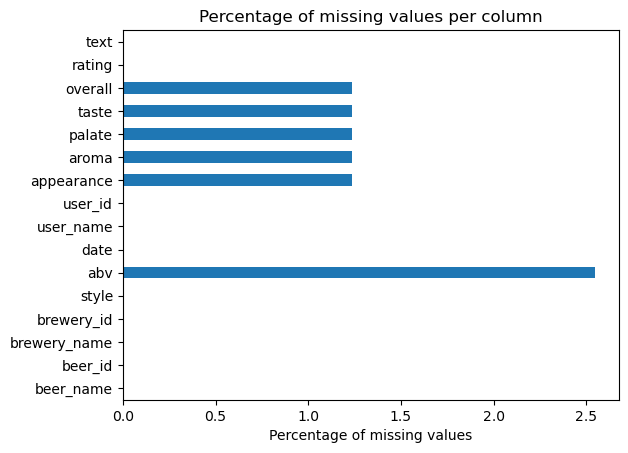

abv                      : 65983 missing values (2.55%)
user_name                :     3 missing values (0.00%)
appearance               : 32009 missing values (1.24%)
aroma                    : 32009 missing values (1.24%)
palate                   : 32009 missing values (1.24%)
taste                    : 32009 missing values (1.24%)
overall                  : 32009 missing values (1.24%)
text                     :     2 missing values (0.00%)


In [29]:
show_missing(reviews)

In [30]:
# making sure that all the missing values of the rating aspects are in the same rows

# print the number of rows that contains a NaN value for each column ['overall', 'taste', 'palate', 'aroma', 'appearance']
print('Number of rows with NaN values for each column :')
for col in ['overall', 'taste', 'palate', 'aroma', 'appearance']:
    print(col, ':', len(reviews[reviews[col].isna()]))
    
print()
# print the number of rows that contains a NaN value for all the rating aspects
missing_values = reviews[['overall', 'taste', 'palate', 'aroma', 'appearance']].isna()
missing_values['all_missing'] = missing_values.all(axis=1)
print(missing_values['all_missing'].value_counts())

Number of rows with NaN values for each column :
overall : 32009
taste : 32009
palate : 32009
aroma : 32009
appearance : 32009

all_missing
False    2557577
True       32009
Name: count, dtype: int64


<blockquote>

All the missing values are in the same rows, and they represent less than 1.5% of the dataset. We can drop them.

</blockquote>

In [31]:
# remove the columns that are not useful for our analysis
reviews_filtered = reviews.drop(columns=['user_name', 'beer_name', 'brewery_name']).copy(deep=True)

# remove the column abv because we have the information in the beers dataframe
reviews_filtered.drop(columns=['abv'], inplace=True)

#remove rows in reviews_filtered that have all_missing True in missing_values
reviews_filtered = reviews_filtered[~missing_values['all_missing']].copy(deep=True)

#remove the two reviews that have no text
reviews_filtered = reviews_filtered[~reviews_filtered['text'].isna()].copy(deep=True)

display(reviews_filtered.sample(3))
print('Shape of reviews_filtered : ', reviews_filtered.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text
1160481,197030,24300,American Double / Imperial Stout,1464948000,zonker17.617493,4.25,4.0,4.25,4.5,4.25,4.29,Black pour with no head but some lacing. Nose...
1077855,2655,607,Hefeweizen,1340013600,drdemento456.330550,3.50,4.0,4.00,4.0,3.50,3.87,A - As expected it has a yellow hazy tint in c...
668437,37477,140,American IPA,1195038000,kegatron.113426,4.00,4.0,4.00,4.5,4.50,4.30,12oz bottle into a pint glass. Pours a beautif...


Shape of reviews_filtered :  (2557575, 12)


In [32]:
show_missing(reviews_filtered)

There are no missing values in this dataset.


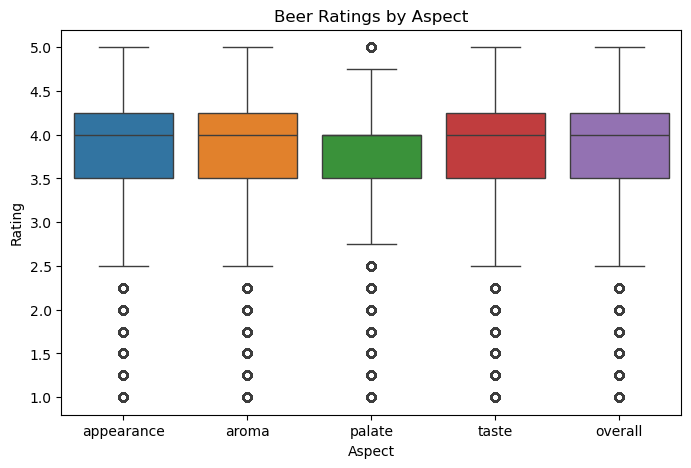

In [33]:
# boxplot for each rating column, appearance, aroma, palate, taste and overall

plt.figure(figsize=(8, 5))
sns.boxplot(data=reviews_filtered[['appearance', 'aroma', 'palate', 'taste', 'overall']])
plt.title('Beer Ratings by Aspect')
plt.xlabel('Aspect')
plt.ylabel('Rating')
plt.show()

### 1.3 Merge datasets 🔗

In [34]:
# Merge reviews with users and beers and breweries
df_merged = reviews_filtered.merge(beers_filtered, how='left', on=['beer_id', 'brewery_id', 'style'])
df_merged = df_merged.merge(users_filtered, how='left', on='user_id')
df_merged = df_merged.merge(breweries_filtered, how='left', on='brewery_id')

display(df_merged.sample(1))
print('Shape of df_merged : ', df_merged.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers
2360605,3646,1339,Tripel,1082196000,billolick.4099,4.0,4.5,4.0,4.5,4.0,4.32,"Large bottle, with cork. Explosive cork releas...",261,216,4.05,9.0,3922,3696,1.071918e+09,"United States, New York",Belgium,9


Shape of df_merged :  (2557575, 22)


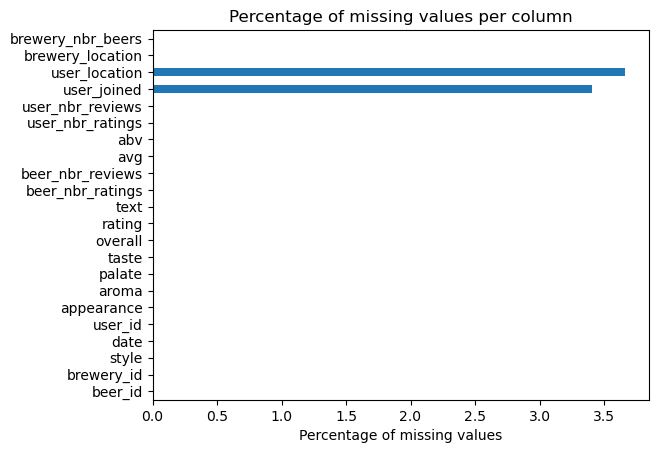

user_joined              : 87150 missing values (3.41%)
user_location            : 93668 missing values (3.66%)


In [35]:
show_missing(df_merged)

In [36]:
# We can replace missing user_joined values with the date of the first review of the user
df_merged['first_review'] = df_merged.groupby('user_id')['date'].transform('min')
df_merged['user_joined'] = df_merged['user_joined'].fillna(df_merged['first_review'])
df_merged.drop(columns=['first_review'], inplace=True)

> We have an almost complete dataset. Only information about the location of users is missing for 3.66% reviews.

In [37]:
# Save to csv
#df_merged.to_csv(dataset_path + 'BeerAdvocateMerged.csv', index=False)
df_merged.to_parquet(dataset_path + 'BeerAdvocateMerged.parquet', index=False)

## 2. Data enrichment 🍺

In [38]:
# load csv from step 1
df = pq.read_table(dataset_path + 'BeerAdvocateMerged.parquet').to_pandas()
#df = pd.read_csv(dataset_path + 'BeerAdvocateMerged.csv')

In [39]:
# for some fine analysis, we will compute the avg appearance, aroma, palate, taste and overall per beer
df['beer_id_avg_appearance'] = df.groupby('beer_id')['appearance'].transform('mean')
df['beer_id_avg_aroma'] = df.groupby('beer_id')['aroma'].transform('mean')
df['beer_id_avg_palate'] = df.groupby('beer_id')['palate'].transform('mean')
df['beer_id_avg_taste'] = df.groupby('beer_id')['taste'].transform('mean')
df['beer_id_avg_overall'] = df.groupby('beer_id')['overall'].transform('mean')

df['beer_id_std'] = df.groupby('beer_id')['overall'].transform('std')
df['beer_id_std_appearance'] = df.groupby('beer_id')['appearance'].transform('std')
df['beer_id_std_aroma'] = df.groupby('beer_id')['aroma'].transform('std')
df['beer_id_std_palate'] = df.groupby('beer_id')['palate'].transform('std')
df['beer_id_std_taste'] = df.groupby('beer_id')['taste'].transform('std')
df['beer_id_std_overall'] = df.groupby('beer_id')['overall'].transform('std')

df_initial = df.copy(deep=True)


In [40]:
display(df.sample(3))
print('Shape of df : ', df.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,beer_id_avg_appearance,beer_id_avg_aroma,beer_id_avg_palate,beer_id_avg_taste,beer_id_avg_overall,beer_id_std,beer_id_std_appearance,beer_id_std_aroma,beer_id_std_palate,beer_id_std_taste,beer_id_std_overall
950052,2237,261,English Barleywine,1051351200,goz.1322,3.00,2.0,2.50,2.50,2.0,2.31,"Pours a hazy orange-brown color, minimal head ...",139,84,3.51,9.0,299,298,1.042196e+09,"United States, Massachusetts","United States, Massachusetts",65,3.613095,3.633929,3.363095,3.461310,3.342262,0.775937,0.528417,0.639378,0.775573,0.794838,0.775937
941558,51959,403,Kölsch,1372845600,uclabrewn84.439438,3.00,3.0,3.25,3.00,3.0,3.03,Best by 7/25/13.Pours a clear golden orange wi...,400,218,3.25,5.0,9944,8768,1.268910e+09,"United States, California","United States, Washington",101,3.198157,3.119816,3.251152,3.241935,3.490783,0.656984,0.559449,0.542776,0.532778,0.580542,0.656984
1537534,152141,31042,Oatmeal Stout,1445076000,kbwalters.445739,4.75,4.0,4.50,3.75,4.0,4.00,Poured cold into a libby stout glass.Look = 4....,114,23,4.13,7.7,272,150,1.270548e+09,"United States, Wisconsin","United States, Indiana",157,4.239130,4.076087,4.271739,4.152174,4.173913,0.191210,0.365239,0.286384,0.360815,0.195680,0.191210


Shape of df :  (2557575, 33)


### 2.1 Serving style 🍾🥤🚰

#### 2.1.1 naive approach

>Since our goal is to look at the influence of the serving style, we need to know how each beer was served.   
A first idea was to use a naive approach. We only look at whether a word specific to as service style has been used. 

In [41]:
def serving_type_naive(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create a new column serving_type_naive that contains the serving type of the beer using the naive approach.

    Parameters:
    - df (pd.DataFrame): The input dataframe.

    Returns:
    - pd.DataFrame: The dataframe with the added 'serving_type_naive' column.
    """
    # Create 3 different columns according to the text review, "bottle", "can", "draft"
    bottle = {'bottle', 'bottled', 'bottles', 'bomber'}
    can = {'can', 'canned', 'cans', }
    draft = {'draft', 'draught', 'tap', 'taps', 'cask', 'growler', 'keg'}
    
    # Create different columns if review text contains the word
    df['bottle'] = df['text'].astype(str).apply(lambda x: any(ele in x.lower() for ele in bottle))
    df['can'] = df['text'].astype(str).apply(lambda x: any(ele in x.lower() for ele in can))
    df['draft'] = df['text'].astype(str).apply(lambda x: any(ele in x.lower() for ele in draft))
    
    # Initialize the serving_type_naive column to 'not_set' with dtype str
    df['serving_type_naive'] = 'not_set'
    df['serving_type_naive'] = df['serving_type_naive'].astype(str)
    
    # if there are more than one true or no true, set the value to 'unknown'
    df.loc[df[['bottle', 'can', 'draft']].sum(axis=1) != 1, 'serving_type_naive'] = 'unknown'

    # drop the columns bottle, can, and draft
    df.drop(['bottle', 'can', 'draft'], axis=1, inplace=True)
    
    return df

#### 2.1.2 Similarity 🍾🥤🚰

> Compute the similarity between the reviews and a list of words specific to each serving style. The list is more exhaustive in this method, using words such as aluminium or cork for can and bottle respectively. Select the serving style with the highest similarity.

In [42]:
def serving_type_sim(df: pd.DataFrame, word_bottle: str = 'data/bottle.txt', word_can: str = 'data/can.txt', word_draft: str = 'data/draft.txt', threshold: float = 0.05) -> pd.DataFrame:
    """
    Compute the cosine similarity between the review text and the list of words for each serving type. 
    Select the serving type with the highest similarity score.

    Parameters:
    - df (pd.DataFrame): The input dataframe.
    - word_bottle (str): Path to the text file containing words related to 'bottle' serving type.
    - word_can (str): Path to the text file containing words related to 'can' serving type.
    - word_draft (str): Path to the text file containing words related to 'draft' serving type.
    - threshold (float): The threshold for considering a serving type based on cosine similarity.

    Returns:
    - pd.DataFrame: The dataframe with the added 'serving_type_sim' column.
    """
    # Read the list of words from the text file
    with open(word_can, 'r') as file:
        word_can = file.read().splitlines()

    with open(word_bottle, 'r') as file:
        word_bottle = file.read().splitlines()

    with open(word_draft, 'r') as file:
        word_draft = file.read().splitlines()

    # Create a TF-IDF vectorizer
    vectorizer = TfidfVectorizer(stop_words='english')

    # Transform the review and words list using TF-IDF
    tfidf_matrix = vectorizer.fit_transform(df['text'].astype(str))

    can_vector = vectorizer.transform([" ".join(word_can)])
    bottle_vector = vectorizer.transform([" ".join(word_bottle)])
    draft_vector = vectorizer.transform([" ".join(word_draft)])

    # Calculate the cosine similarity
    cosine_sim_can = cosine_similarity(tfidf_matrix, can_vector)
    cosine_sim_bottle = cosine_similarity(tfidf_matrix, bottle_vector)
    cosine_sim_draft = cosine_similarity(tfidf_matrix, draft_vector)

    # Get the maximum similarity score and corresponding serving type
    max_sim = np.maximum.reduce([cosine_sim_bottle, cosine_sim_can, cosine_sim_draft])
    serving_type = np.where(max_sim >= threshold, np.array(['bottle', 'can', 'draft'])[np.argmax([cosine_sim_bottle, cosine_sim_can, cosine_sim_draft], axis=0)], 'unknown')

    # Add the serving_type_sim column to the dataframe
    df['serving_type_sim'] = serving_type

    return df

#### 2.1.3 Rule-based approach 🍾🥤🚰

> Homemade algorithm used to find the serving type using a rule-based approach.

In [59]:
nlp = spacy.load("en_core_web_sm")
from spacy.tokens import Doc

def differentiate_can(doc: Doc) -> List[str]:
    """
    Differentiate between the noun and verb form of the word "can" in the review text.

    Parameters:
    - doc (spacy.tokens.Doc): The input SpaCy Doc object representing the review text.

    Returns:
    - List[str]: A list indicating whether each occurrence of "can" is used as a noun or a verb.
    """
    verbes_nom = []
    for token in doc:
        if token.text.lower() == "can" and any(t.dep_ == "aux" for t in token.head.children):
            verbes_nom.append("verb")
        elif token.text.lower() == "can":
            verbes_nom.append("noun")

    return verbes_nom

def remove_conditional(doc: Doc) -> Doc:
    """
    Remove parts of the review text that are in the conditional form.

    Parameters:
    - doc (spacy.tokens.Doc): The input SpaCy Doc object representing the review text.

    Returns:
    - spacy.tokens.Doc: The modified SpaCy Doc object with conditional parts removed.
    """
    modified_tokens = []
    remove_sentence = False

    for sent in doc.sents:
        for token in sent:
            if remove_sentence:
                continue
            if token.text.lower() in {"would", "could", "'d", "will"}:
                subtree = [t.text for t in token.subtree]
                modified_tokens.extend(subtree[:-1])
                remove_sentence = True
            else:
                modified_tokens.append(token.text)

    modified_text = " ".join(modified_tokens)

    return nlp(modified_text)

def extract_serving_style(review: str) -> str:
    """
    Return the serving style of the beer using the rule-based approach.

    Parameters:
    - review (str): The input text of the beer review.

    Returns:
    - str: The serving style of the beer.
    """
    bottle = {'bottle', 'bottled', 'bottles', 'bomber'}
    can = {'can', 'canned', 'cans'}
    draft = {'draft', 'draught', 'tap', 'taps', 'cask', 'growler', 'on-tap', 'keg'}

    modified_doc = remove_conditional(nlp(review))
    #modified_doc = nlp(review)

    serving_styles = set()

    if any(word in modified_doc.text.lower() for word in bottle):
        serving_styles.add("bottle")
    if any(word in modified_doc.text.lower() for word in can) and "noun" in differentiate_can(modified_doc):
        serving_styles.add("can")
    if any(word in modified_doc.text.lower() for word in draft):
        serving_styles.add("draft")

    serving_style = serving_styles.pop() if len(serving_styles) == 1 else 'unknown'

    return serving_style

def process_row(row: pd.Series) -> str:
    """
    Process a row of a DataFrame, extracting the serving style of the beer from the 'text' column.

    Parameters:
    - row (pd.Series): A row of a DataFrame containing a 'text' column.

    Returns:
    - str: The serving style of the beer.
    """
    serving_style = extract_serving_style(row.text)
    return serving_style

def serving_type_rulebased(df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply the rule-based serving type extraction function to each row of the DataFrame in parallel.

    Parameters:
    - df (pd.DataFrame): The input dataframe.

    Returns:
    - pd.DataFrame: The dataframe with the added 'serving_type_rulebased' column.
    """
    # Number of threads to run in parallel (adjust based on your system)
    num_threads = 6
    
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        # Apply the function in parallel to each row of the DataFrame
        results = list(tqdm(executor.map(process_row, df.itertuples(index=False)), total=len(df)))

    # Add the results to the DataFrame
    df['serving_type_rulebased'] = results
    
    return df

In [64]:
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize

#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')


def differentiate_can_tense(doc: Doc) -> List[str]:
    """
    Differentiate between the noun and verb form of the word "can" in the review text.

    Parameters:
    - doc (spacy.tokens.Doc): The input SpaCy Doc object representing the review text.

    Returns:
    - List[str]: A list indicating whether each occurrence of "can" is used as a noun or a verb.
    """
    verbes_nom = []
    for token in doc:
        if token.text.lower() == "can" and any(t.dep_ == "aux" for t in token.head.children):
            verbes_nom.append("verb")
        elif token.text.lower() == "can":
            verbes_nom.append("noun")

    return verbes_nom            


def detect_tense_before_containers(text):

    bottle = {'bottle', 'bottled', 'bottles', 'bomber'}
    can = {'can', 'canned', 'cans'}
    draft = {'draft', 'draught', 'tap', 'taps', 'cask', 'on-tap','growler', 'keg'}
    modified_doc = nlp(text)
    
    sentences = nltk.sent_tokenize(text)

    container = []
    poss =[]

    # Process each sentence
    for sentence in sentences:
        # Tokenize the sentence into words
        words = word_tokenize(sentence)
        # Perform part-of-speech tagging
        pos_tags = pos_tag(words)
        # Create a spaCy doc for the sentence
        doc = nlp(" ".join(words))

        # Identify the tense based on the POS tags
        for i in range(len(pos_tags)):
            word, pos = pos_tags[i]

            if word.lower() in bottle:
                word = 'bottle'
                pos = 'NN'
            elif word.lower() in can and "noun" in differentiate_can_tense(modified_doc):
                pos = 'NN'
                #print(pos)
                word = 'can'
            elif word.lower() in draft:
                word = 'draft'

            # Check for beer container words
            if word.lower() in ['bottle', 'can', 'draft']:
    
                # A bool to check if there is a verb before the word
                #verb_bool = False

                # Check that the word is not a verb
                if pos not in ['VBD', 'VBN', 'VBG', 'VBZ', 'VBP', 'MD']:
                    verb_bool = False
                        # Find the tense of the verb just before the container word
                    for j in range(i - 1, -1, -1):
                        prev_word, prev_pos = pos_tags[j]
    
                            # Don't want the serving type if it is in the future
                        if prev_pos in ['MD']:
                            verb_bool = True
                                #print(prev_pos)
                            #break
    
                        if prev_pos in ['VBG', 'VBZ', 'VBP']:
                            poss.append(prev_pos)
                            container.append(word)
                            verb_bool = False
                            #break
                            
                            
                                
                        if prev_pos in ['VBD', 'VBN']:
                            poss.append(prev_pos)
                            container.append(word)
                            return container
                            #verb_bool = False
                            #print(prev_pos)
                               # break
                                
                                
                    # If there are no verbs before the word, it must be this serving style
                    if not verb_bool:
                        container.append(word)
                        return container
                    
                    
def process_row_tb(row: pd.Series) -> str:
    """
    Process a row of a DataFrame, extracting the serving style of the beer from the 'text' column.

    Parameters:
    - row (pd.Series): A row of a DataFrame containing a 'text' column.

    Returns:
    - str: The serving style of the beer.
    """
    serving_style = extract_serving_style_tensebased(row.text)
    return serving_style

def extract_serving_style_tensebased(review: str) -> str:
    container = detect_tense_before_containers(review)
    if container is None or len(container) == 0 or len(set(container)) > 1:
        serving_style = 'unknown'
    else:
        container_str = str(container[0])
        serving_style = container_str
    return serving_style
    
def serving_type_tensebased(df):
    # Number of threads to run in parallel (adjust based on your system)
    num_threads = 6
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        # Apply the function in parallel to each row of the DataFrame
        results = list(tqdm(executor.map(process_row_tb, df.itertuples(index=False)), total=len(df)))

    # Add the results to the DataFrame
    df['serving_type_rulebased'] = results
    
    return df

> This function is quite simple and we will try to adapt it further in Milestone P3. On the test performed below on the hand-labeled dataset, we applied this function to extract the serving styles. We first did it without the ```remove_conditional``` function, and it took 2.6s for an accuracy of 91.2%. With the function, it took 4.5s for an accuracy of 91.6%. Therefore, the choice was made to not use the function as it almost doubled runtime.

#### 2.1.4 Test on sample df

<blockquote>

To test which method performed best to retrieve the serving style of a beer, we manually labelled 250 reviews sampled randomly on the merged dataset. Each member of the group labelled 50 reviews as "unknown", "draft", "can" or "bottle".<break>


The goal was to learn more about the reviews, and find pattern that could help us for the rule-based method. After a few reviews, we added some words related to draft for example.


</blockquote>

##### 2.1.4.1 Obtain a df with true serving types

In [45]:
#250 reviews for function evaluation (manually labelled)
df_eval = df.sample(n=250, random_state=46).copy(deep=True)
df_eval['true_serving_type'] = 'not_set'

In [46]:
df_eval['true_serving_type'].value_counts()

true_serving_type
not_set    250
Name: count, dtype: int64

In [47]:
# Function used to display a review and label the serving style
#idx = display_review(df_eval)
#df_eval = update_review_serving_type(df_eval, idx)

In [48]:
# df_eval.to_csv('data/BeerAdvocateEval.csv', index=False)
df_eval = pd.read_csv('data/BeerAdvocateEval.csv')

In [49]:
# Distribution of the serving types in the evaluation set
df_eval['true_serving_type'].value_counts()

true_serving_type
unknown    144
bottle      75
draft       24
can          7
Name: count, dtype: int64

##### 2.1.4.2 Call each function and evaluate (time and accuracy)

In [50]:
display(df_eval.sample(3))

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,true_serving_type
194,65301,23675,American Strong Ale,1332669600,nickfl.68596,4.5,4.5,4.00,4.00,4.00,4.15,A - poured with a small head of off white foam...,39,16,4.07,9.5,5328,1990,1.141729e+09,"United States, Florida","United States, Arizona",37,unknown
159,127319,28091,American Pale Wheat Ale,1437300000,tucquan.164286,4.0,3.5,3.75,4.00,3.75,3.81,"Had thus on 2015-07-19 in Harrusburg, PA at Th...",85,9,3.69,4.8,1927,1442,1.192097e+09,"United States, Pennsylvania","United States, Pennsylvania",143,draft
188,62103,160,English Strong Ale,1499162400,vader444.1171132,4.0,4.0,2.50,2.25,3.00,2.95,500ml bottle poured into nonic pint glass. I w...,458,172,3.75,6.6,128,111,1.472206e+09,Scotland,England,75,bottle


In [51]:
t1 = time.time()
df_eval = serving_type_naive(df_eval)
t_naive = time.time() - t1
print(f"Naive method took {t_naive} seconds")

print('Naive method accuracy:', compute_accuracy(df_eval['serving_type_naive'], df_eval['true_serving_type']))

Naive method took 0.006373882293701172 seconds
correct_count: 117, total_count: 250
Naive method accuracy: 0.468


In [52]:
t1 = time.time()
df_eval = serving_type_sim(df_eval, threshold=0.03)
t_sim = time.time() - t1
print(f"Similarity method took {t_sim} seconds")

print('Similarity method accuracy:', compute_accuracy(df_eval['serving_type_sim'], df_eval['true_serving_type']))

Similarity method took 0.021040916442871094 seconds
correct_count: 160, total_count: 250
Similarity method accuracy: 0.64


In [53]:
t1 = time.time()
df_eval = serving_type_rulebased(df_eval)
t_rulebased = time.time() - t1
print(f"Rulebased method took {t_rulebased} seconds")

print('Rulebased method accuracy:', compute_accuracy(df_eval['serving_type_rulebased'], df_eval['true_serving_type']))

  0%|          | 1/250 [00:00<00:50,  4.98it/s]

100%|██████████| 250/250 [00:04<00:00, 59.82it/s]

Rulebased method took 4.340963125228882 seconds
correct_count: 236, total_count: 250
Rulebased method accuracy: 0.944


In [65]:
t1 = time.time()
df_eval = serving_type_tensebased(df_eval)
t_rulebased = time.time() - t1
print(f"Tensebased method took {t_rulebased} seconds")
print('Tensebased method accuracy:', compute_accuracy(df_eval['serving_type_tensebased'], df_eval['true_serving_type']))

100%|██████████| 250/250 [00:05<00:00, 43.63it/s]

Tensebased method took 5.911672115325928 seconds
correct_count: 235, total_count: 250
Tensebased method accuracy: 0.94


In [55]:
#print one random misidentified review
df_misclassified = df_eval[df_eval['serving_type_tensebased'] != df_eval['true_serving_type']].copy(deep=True)
for index, row in df_misclassified.sample(1).iterrows():
    print(f"Review {index}:\n{row['text']}\nTense-based serving type: {row['serving_type_tensebased']}\nTrue serving type: {row['true_serving_type']}\n")
    print(differentiate_can(nlp(row['text'])))

Review 31:
poured from 12 oz. bottledeep reddish mahogany or dark amber honey colored with enough haze to render it opaque. creamy off-white head that left chunky bits of lacing stuck to the inside of the glass all the way to the bottom. light floral scent with malt wafting though and a faint tingle on the nose suggesting hops content. tasted caramel and nut flavors in the initial sweet malt impression - toasty. bitterness creeps in soon after adding bite to the malt before crushing it with a heavy hops burst mid-palate. strong finish that is noticably more hops than malt (despite the touted &quot;balanced finish&quot;) and has great lingering power. felt smooth at first, then more medium-bodied and a bit chewier or oily. appropriate carbonation. very decent brew if you're in the mood for something less pale with plenty of hops.
Tense-based serving type: unknown
True serving type: bottle

[]


> It is quite clear that the rulebased method is the best one. It takes longer to run, but the accuracy gain is worth it. We will use this method to classify the reviews between the 3 serving styles. By exploring the reviews that get classified as ```unknown``` we realize that the main reason is that they contain two or more serving styles, so in Milestone P3 our objective is to adapt further the classification to solve this problem. An idea could be to perform a temporal analysis or to use the ```remove_conditional``` function. However, this will negatively impact run time.

In [56]:
# Classification of serving type on the whole dataset
#### 8h run-time
#df = serving_type_rulebased(df)
df = pq.read_table(dataset_path + 'BA_classified2.parquet').to_pandas()

In [66]:
df_unknown = df[df['serving_type_rulebased'] == 'unknown'].copy(deep=True)
print('Number of reviews with unknown serving type:', len(df_unknown))

Number of reviews with unknown serving type: 1523841


In [67]:
df_unknown = serving_type_tensebased(df_unknown)

100%|██████████| 1523841/1523841 [11:30:47<00:00, 36.77it/s]   


In [68]:
# count the number of reviews for each serving_type_rulebased
print(df_unknown['serving_type_rulebased'].value_counts(normalize=False))

# percentage of unknown serving type
print('Percentage of unknown serving type:', round(df_unknown['serving_type_rulebased'].value_counts(normalize=True)['unknown']*100, 2), '%')

serving_type_rulebased
unknown    1421479
bottle       62127
draft        28922
can          10726
Can            426
CAN            161
Name: count, dtype: int64
Percentage of unknown serving type: 93.28 %


In [69]:
# change the "Can" "CAN" in serving_type_rulebased to "can"
df_unknown.loc[df_unknown['serving_type_rulebased'] == 'Can', 'serving_type_rulebased'] = 'can'
df_unknown.loc[df_unknown['serving_type_rulebased'] == 'CAN', 'serving_type_rulebased'] = 'can'


In [70]:
#save to parquet
df_unknown.to_parquet(dataset_path + 'BA_classified_unknown.parquet', index=False)

In [74]:
# show one review for each serving_type_rulebased
for serving_type in df_unknown['serving_type_rulebased'].unique():
    print('Serving type:', serving_type)
    print(df_unknown[df_unknown['serving_type_rulebased'] == serving_type].sample(1, random_state= 46)['text'].values[0])
    #print index of the review
    print(df_unknown[df_unknown['serving_type_rulebased'] == serving_type].sample(1).index[0])

Serving type: unknown
Sierra Nevada - Bigfoot Barleywine Style Ale, poured into a wine goblet.Look - Filtered deep amber ruby with good sized soapy head. Abundance of lacing.Smell - Citrus and pine dank hops intertwined with amber/red malts. Aroma is strong and full.Taste - Rich malts with definitely alcohol taste (slightly off putting), finishes bitter pine hop blast.Mouthfeel - Full bodied with medium carbonation. Sticky coating from malts. Definite boozy kicker. Sipper.Overall - This is one heck of a mean brew. the pine hop bitter mixed with definite alcohol creates almost a solvent-like taste but you acclimate to it as you drink it. Watch out for hangovers with this one!
655813
Serving type: bottle
Like every college student (and yes I am over 21) I need a cheap beer. Other budget beers including Keystone, Coors, Icehouse, Busch, and Miller High Life strike me as watered down and/or overpriced for what it is.Had a chance to get a quart of Best for a buck and wasn't disappointed. I 

In [75]:
#replace the serving_type_rulebased in df with the serving_type_rulebased in df_unknown
df.loc[df['serving_type_rulebased'] == 'unknown', 'serving_type_rulebased'] = df_unknown['serving_type_rulebased']

In [76]:
# save to parquet
df.to_parquet(dataset_path + 'BA_classified3.parquet', index=False)

> The extraction took 12h20 on a recent MacAir with an 8 cores CPU!!

> The extraction took 14h on a recent MacAir with an 8 cores CPU. With our previous estimations on run time, using the ```remove_conditional``` function would have taken 30h. We will try to adapt the function ```extract_serving_style``` by adding new rules, based on the different tenses of the sentences. As explained before, there is a big potential to reduce less the dataset (have less 'unknown' samples) if we manage to extract the style in reviews which have 2 serving styles present. Therefore, we know for a fact that these reviews contain the true serving style, which we will try to retrieve. The additional rules that we plan to use based on the tense of the sentences will probably increase this number a lot too, so we might need to use an online GPU solution.

In [60]:
display(df.sample(3))
print('Shape of df : ', df.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,beer_id_avg_appearance,beer_id_avg_aroma,beer_id_avg_palate,beer_id_avg_taste,beer_id_avg_overall,beer_id_std,beer_id_std_appearance,beer_id_std_aroma,beer_id_std_palate,beer_id_std_taste,beer_id_std_overall,serving_type_rulebased
292975,4014,1315,Hefeweizen,1143799200,evilkeith.53115,4.00,3.50,3.5,3.50,4.00,3.63,Pours a cloudy hazy dark orange color with two...,166,97,3.69,5.4,242,241,1.133608e+09,"United States, Alabama",Germany,14,3.845361,3.585052,3.631443,3.597938,3.796392,0.470939,0.475224,0.524015,0.443549,0.483526,0.470939,unknown
1994280,126808,287,Belgian Pale Ale,1420023600,defencorps.117609,3.75,4.00,4.0,4.00,4.00,3.99,Been a while since I've tried a new Bells beer...,531,105,3.53,4.8,2661,2632,1.169118e+09,"United States, Oregon","United States, Michigan",312,3.656250,3.487981,3.632212,3.514423,3.531250,0.493511,0.526238,0.502880,0.504779,0.536108,0.493511,unknown
629581,41815,2210,Russian Imperial Stout,1434016800,gregaroo.752164,4.50,4.75,4.5,4.75,4.75,4.71,Updates:2-12-17 - Found a Proprietor's Reserv...,6487,1240,4.54,14.0,681,300,1.378289e+09,"United States, Pennsylvania","United States, California",207,4.363154,4.483456,4.474469,4.590278,4.511234,0.401508,0.416300,0.398128,0.453941,0.397919,0.401508,unknown


Shape of df :  (2557575, 34)


### 2.2 Data filtering 🧹
Since our analysis will be focused on the serving style, we will remove all reviews where no serving style was identified. 

<div class="alert alert-block alert-warning">
<b>Alert:</b> By doing so, we are reducing our dataset by more than half. We will need to check if our dataset is still representative of the initial one. 
</div>

In [3]:
df = pd.read_parquet(dataset_path + 'BA_classified3.parquet')

In [4]:
df.sample(3)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,beer_id_avg_appearance,beer_id_avg_aroma,beer_id_avg_palate,beer_id_avg_taste,beer_id_avg_overall,beer_id_std,beer_id_std_appearance,beer_id_std_aroma,beer_id_std_palate,beer_id_std_taste,beer_id_std_overall,serving_type_rulebased
2099656,62755,9629,American Black Ale,1353150000,axeman9182.356817,4.00,4.00,3.00,3.50,3.5,3.60,12 oz bottle courtesy of radio2525 in the Barr...,276,75,3.86,5.0,739,708,1.249466e+09,"United States, New Jersey","United States, Michigan",449,3.950000,3.866667,3.726667,3.836667,3.846667,0.569337,0.516616,0.608683,0.598666,0.680934,0.569337,bottle
2510100,18057,380,Bière de Garde,1106132400,paterlodie.8814,3.50,2.00,2.00,2.00,1.5,1.99,Best before 20-10-05 so well in time for a try...,11,9,3.40,6.4,1028,1028,1.095761e+09,Belgium,France,35,3.777778,3.555556,3.500000,3.444444,3.444444,0.881917,0.565194,0.726483,0.707107,0.807947,0.881917,unknown
1565949,4582,1170,Witbier,1420974000,bwed.653268,3.75,3.75,3.25,3.25,3.5,3.45,12 oz. bottle poured into a snifter.A- Bright ...,433,155,3.56,4.5,445,445,1.325848e+09,"United States, Colorado","United States, Indiana",172,3.482026,3.493464,3.562092,3.517974,3.785948,0.654827,0.503364,0.536457,0.549582,0.553179,0.654827,bottle


In [5]:
# count the number of reviews for each serving_type_rulebased
print(df['serving_type_rulebased'].value_counts(normalize=False))

# percentage of unknown serving type
print('Percentage of unknown serving type:', round(df['serving_type_rulebased'].value_counts(normalize=True)['unknown']*100, 2), '%')

serving_type_rulebased
unknown    1421479
bottle      805490
draft       266020
can          64586
Name: count, dtype: int64
Percentage of unknown serving type: 55.58 %


In [6]:
# drop rows where serving_type_rulebased is unknown
df = df[df['serving_type_rulebased'] != 'unknown'].copy(deep=True)

In [8]:
# count the number of reviews for each serving_type_rulebased
print(df['serving_type_rulebased'].value_counts(normalize=True))

serving_type_rulebased
bottle    0.708998
draft     0.234153
can       0.056849
Name: proportion, dtype: float64


### 2.3 Sentiment analysis 📝

<blockquote>

In this part of the notebook, we tried to assess whether a review was on the positive or negative side with a polarity analysis. We also looked at subjectivity.
If a serving style appears to have statistically higher ratings than another, we could look if the polarity of the reviews reaches the same conclusion.

</blockquote>

In [13]:
# df = sentiment_analysis(df)
# df.to_parquet(dataset_path + 'BA_sentiment.parquet', index=False)

df= pd.read_parquet(dataset_path + 'BA_sentiment.parquet')

In [14]:
display(df.sample(3))
print('Shape of df : ', df.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,beer_id_avg_appearance,beer_id_avg_aroma,beer_id_avg_palate,beer_id_avg_taste,beer_id_avg_overall,beer_id_std,beer_id_std_appearance,beer_id_std_aroma,beer_id_std_palate,beer_id_std_taste,beer_id_std_overall,serving_type_rulebased,polarity,subjectivity
789461,111616,46317,American IPA,1476266400,drinkthemall.603975,4.25,4.25,4.25,4.25,4.25,4.25,Poured just a tad bit into a 4oz snifter to se...,3176,405,4.57,7.0,206,98,1.307873e+09,"United States, California","United States, Vermont",27,4.353846,4.568590,4.560256,4.614744,4.580769,0.333270,0.517171,0.371642,0.359713,0.378750,0.333270,can,0.012698,0.426190
38878,1733,178,English Strong Ale,1236942000,beersox.89119,4.00,3.50,3.50,3.50,3.50,3.53,"500ml bottle into nonic.Deep, dark and cloudy ...",167,122,3.67,7.5,1160,1160,1.153130e+09,"United States, Virginia",England,40,3.696721,3.690574,3.682377,3.657787,3.598361,0.782398,0.657309,0.600493,0.725165,0.698435,0.782398,bottle,0.043333,0.466667
784511,62739,24056,American Double / Imperial IPA,1492682400,airbob.826510,4.25,3.75,4.25,4.00,4.00,3.98,"A - About two fingers of creamy, dense white h...",458,105,4.34,9.9,921,193,1.405678e+09,None,"United States, Wyoming",78,4.288095,4.340476,4.309524,4.388095,4.350000,0.399218,0.396470,0.396990,0.416781,0.445303,0.399218,can,0.268951,0.506923


Shape of df :  (1136096, 36)


### 2.4 Readability score 📖

> In this step, we checked the readability score of the review. This might not be necessary but it was still interesting to compare which ratings had higher readability score.

In [17]:
# df = compute_readability(df)
# df.to_parquet(dataset_path + 'BA_readability.parquet', index=False)

df = pd.read_parquet(dataset_path + 'BA_readability.parquet')

In [27]:
display(df.sample(3))
print('Shape of df : ', df.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,beer_id_avg_appearance,beer_id_avg_aroma,beer_id_avg_palate,beer_id_avg_taste,beer_id_avg_overall,beer_id_std,beer_id_std_appearance,beer_id_std_aroma,beer_id_std_palate,beer_id_std_taste,beer_id_std_overall,serving_type_rulebased,polarity,subjectivity,readability_score
1069113,112126,259,Belgian Pale Ale,1491732000,woodychandler.5708,4.25,4.0,3.5,3.75,3.75,3.82,As I remarked in the New Beer Sunday...,359,79,3.99,4.8,4526,4526,1.081505e+09,"United States, Pennsylvania",Belgium,18,4.061594,3.938406,3.978261,4.036232,4.036232,0.349041,0.414369,0.352005,0.387628,0.379326,0.349041,bottle,0.258594,0.519359,70.94
29235,19426,71,Old Ale,1128506400,rocketmotor.8161,4.50,4.5,5.0,4.00,2.50,3.95,"2004 Vintage, bottle number 82121.Po...",1275,673,4.17,8.5,21,21,1.093342e+09,"United States, Illinois",England,61,4.127794,4.122951,4.163189,4.228390,4.094262,0.543414,0.439605,0.459732,0.505390,0.510431,0.543414,bottle,0.262319,0.547464,86.50
962602,79356,8,American Porter,1348826400,uclabrewn84.439438,3.50,3.5,3.5,3.00,3.00,3.20,Bottled 2/14/12.Pours an almost opaq...,50,16,3.63,6.0,9944,8768,1.268910e+09,"United States, California","United States, Oregon",186,3.750000,3.593750,3.625000,3.625000,3.562500,0.442531,0.516398,0.375000,0.619139,0.341565,0.442531,bottle,0.019136,0.420216,81.12


Shape of df :  (1136096, 37)


### 2.5 Metrics udpdate 📊

> The metrics updated in this step will be compared with the previous ones (user_nbr_reviews, beer_nbr_reviews, avg). Since our dataset has been reduced by half, approximately half of the reviews were lost. We will check if our final dataset is still representative of the initial one by comparing the average rating of a beer before and after the filtering. 

In [28]:
# compute the number of valid reviews per user
df['user_filtered_nbr_reviews'] = df.groupby('user_id')['user_id'].transform('count')

# compute the number of valid reviews per beer
df['beer_id_filtered_nbr_reviews'] = df.groupby('beer_id')['beer_id'].transform('count')

# compute the avg rating per beer
df['beer_id_filtered_avg'] = df.groupby('beer_id')['rating'].transform('mean')
df['beer_id_filtered_std'] = df.groupby('beer_id')['rating'].transform('std')

In [29]:
# for some fine analysis, we will compute the avg appearance, aroma, palate, taste and overall per beer
df['beer_id_filtered_avg_appearance'] = df.groupby('beer_id')['appearance'].transform('mean')
df['beer_id_filtered_avg_aroma'] = df.groupby('beer_id')['aroma'].transform('mean')
df['beer_id_filtered_avg_palate'] = df.groupby('beer_id')['palate'].transform('mean')
df['beer_id_filtered_avg_taste'] = df.groupby('beer_id')['taste'].transform('mean')
df['beer_id_filtered_avg_overall'] = df.groupby('beer_id')['overall'].transform('mean')

df['beer_id_filtered_std_appearance']= df.groupby('beer_id')['appearance'].transform('std')
df['beer_id_filtered_std_aroma']= df.groupby('beer_id')['aroma'].transform('std')
df['beer_id_filtered_std_palate']= df.groupby('beer_id')['palate'].transform('std')
df['beer_id_filtered_std_taste']= df.groupby('beer_id')['taste'].transform('std')
df['beer_id_filtered_std_overall']= df.groupby('beer_id')['overall'].transform('std')


In [30]:
display(df.sample(3))
print('Shape of df : ', df.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,beer_id_avg_appearance,beer_id_avg_aroma,beer_id_avg_palate,beer_id_avg_taste,beer_id_avg_overall,beer_id_std,beer_id_std_appearance,beer_id_std_aroma,beer_id_std_palate,beer_id_std_taste,beer_id_std_overall,serving_type_rulebased,polarity,subjectivity,readability_score,user_filtered_nbr_reviews,beer_id_filtered_nbr_reviews,beer_id_filtered_avg,beer_id_filtered_std,beer_id_filtered_avg_appearance,beer_id_filtered_avg_aroma,beer_id_filtered_avg_palate,beer_id_filtered_avg_taste,beer_id_filtered_avg_overall,beer_id_filtered_std_appearance,beer_id_filtered_std_aroma,beer_id_filtered_std_palate,beer_id_filtered_std_taste,beer_id_filtered_std_overall
1012520,62397,1146,American Double / Imperial Stout,1304503200,montrose79.442583,5.00,5.0,5.0,5.0,5.0,5.00,Had this once from the bottle and th...,1373,367,4.70,13.0,35,10,1.269688e+09,"United States, New York","United States, Illinois",869,4.336777,4.692837,4.623278,4.763085,4.601240,0.441594,0.485683,0.351600,0.420210,0.335515,0.441594,bottle,0.198024,0.449808,84.88,4,241,4.664564,0.267664,4.303942,4.693983,4.606846,4.753112,4.587137,0.489148,0.333815,0.455001,0.322330,0.453207
1019510,110541,31678,Saison / Farmhouse Ale,1478775600,guyfawkes.590591,4.25,4.5,4.5,4.5,4.5,4.49,2015 vintage; drank 11/6/15 @ the Ya...,942,148,4.08,6.8,620,620,1.302170e+09,"United States, Illinois","United States, Illinois",80,4.134191,4.102941,4.095588,4.125000,4.115809,0.344142,0.372564,0.396128,0.330626,0.368932,0.344142,bottle,0.086667,0.614667,88.43,461,45,4.075778,0.272117,4.011111,4.050000,4.077778,4.094444,4.077778,0.357372,0.347883,0.276043,0.302869,0.286149
753107,90197,25567,American Stout,1454410800,evilyak.20903,4.25,3.5,4.0,4.0,4.0,3.90,"pours dark brown, with a tan head an...",66,26,4.11,8.0,306,279,1.117274e+09,"United States, Minnesota","United States, Minnesota",29,4.134615,4.125000,4.134615,4.096154,4.125000,0.310242,0.362152,0.340955,0.340814,0.324630,0.310242,can,0.025000,0.679167,102.20,32,8,4.002500,0.210289,4.093750,4.031250,3.937500,3.937500,4.093750,0.229031,0.281498,0.258775,0.258775,0.265165


Shape of df :  (1136096, 51)


### 2.6 Countries grouping 🌍

In [34]:
# Group the countries by world region
countries = pd.read_csv('data/countries_region.csv')[['name', 'sub-region']]
countries.sample(3)

,name,sub-region
13,Australia,Australia and New Zealand
137,Malta,Southern Europe
229,Turks and Caicos Islands,Latin America and the Caribbean


In [35]:
# add a column user_country with the country of the user
df['user_location'] = df['user_location'].fillna('Unknown')
df['user_country'] = df['user_location'].apply(lambda x: 'United States of America' if 'United States, ' in x else x)

df.sample(3)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,beer_id_avg_appearance,beer_id_avg_aroma,beer_id_avg_palate,beer_id_avg_taste,beer_id_avg_overall,beer_id_std,beer_id_std_appearance,beer_id_std_aroma,beer_id_std_palate,beer_id_std_taste,beer_id_std_overall,serving_type_rulebased,polarity,subjectivity,readability_score,user_filtered_nbr_reviews,beer_id_filtered_nbr_reviews,beer_id_filtered_avg,beer_id_filtered_std,beer_id_filtered_avg_appearance,beer_id_filtered_avg_aroma,beer_id_filtered_avg_palate,beer_id_filtered_avg_taste,beer_id_filtered_avg_overall,beer_id_filtered_std_appearance,beer_id_filtered_std_aroma,beer_id_filtered_std_palate,beer_id_filtered_std_taste,beer_id_filtered_std_overall,user_country
164136,46596,11031,American Double / Imperial IPA,1275818400,dirtylou.19214,4.00,4.0,4.0,4.0,4.0,4.00,on-tap at in de wildeman in amsterda...,163,66,3.82,9.2,2233,2093,1.115892e+09,"United States, Washington",Netherlands,359,3.834615,3.915385,3.753846,3.811538,3.796154,0.553561,0.472437,0.532676,0.542153,0.596262,0.553561,draft,0.466667,0.400000,40.04,1520,35,3.854286,0.470146,3.842857,3.914286,3.778571,3.85,3.828571,0.470004,0.517854,0.480393,0.553066,0.534719,United States of America
1062478,209280,47,Gueuze,1462442400,kevanb.589224,3.75,4.0,3.5,4.0,4.0,3.94,"750ml bottle, decanted in a 1L Boon ...",23,9,4.08,7.0,986,986,1.301911e+09,"United States, Illinois",Belgium,43,4.000000,4.111111,4.027778,4.055556,4.083333,0.279508,0.250000,0.181621,0.363242,0.166667,0.279508,bottle,0.251223,0.668086,78.18,816,3,3.996667,0.060277,3.833333,4.083333,3.666667,4.00,4.083333,0.144338,0.144338,0.144338,0.000000,0.381881,United States of America
247035,213243,220,American Wild Ale,1463306400,themaniacalone.37950,4.00,4.0,4.0,4.0,4.0,4.00,On-tap 5/15/2016 at Flynn’s in Mansf...,835,206,3.81,5.7,5243,4948,1.125742e+09,"United States, Rhode Island","United States, California",278,3.916262,3.861650,3.830097,3.791262,3.807039,0.527383,0.453270,0.499668,0.511709,0.625765,0.527383,draft,0.061863,0.428551,80.82,4880,82,3.799390,0.460342,3.960366,3.835366,3.817073,3.75,3.786585,0.441779,0.466831,0.500075,0.549972,0.481321,United States of America


In [36]:
# rename or add country with names different than in user_country

# rename the column of countries that cause problems 
def rename_countries(old_name, new_name):
    countries['name'] = countries['name'].replace(old_name, new_name)
    return

rename_countries('Bolivia (Plurinational State of)', 'Bolivia')
rename_countries('Tanzania, United Republic of', 'Tanzania')
rename_countries('South Georgia and the South Sandwich Islands', 'South Georgia and South Sandwich Islands')
rename_countries('Fiji', 'Fiji Islands')
rename_countries('New Zealand', 'Aotearoa')
rename_countries('Taiwan, Province of China', 'Taiwan')
rename_countries('North Macedonia', 'Macedonia')
rename_countries('Viet Nam', 'Vietnam')
rename_countries('Russian Federation', 'Russia')
rename_countries('Czechia', 'Czech Republic')
rename_countries('Slovakia', 'Slovak Republic')
rename_countries('Svalbard and Jan Mayen', 'Svalbard and Jan Mayen Islands')

new_countries = pd.DataFrame({'name': ['England', 'Wales', 'Northern Ireland', 'Scotland', 'Unknown'], 'sub-region': ['Northern Europe','Northern Europe','Northern Europe','Northern Europe', 'Unknown']})

countries = pd.concat([countries, new_countries]).drop_duplicates().reset_index(drop=True)

In [37]:
# add column user_subregion to df
df = df.merge(countries[['name', 'sub-region']], left_on='user_country', right_on='name', how='left')
df.rename(columns={'sub-region': 'user_subregion'}, inplace=True)
df = df.drop(columns=['name'])

df.sample(5)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,beer_id_avg_appearance,beer_id_avg_aroma,beer_id_avg_palate,beer_id_avg_taste,beer_id_avg_overall,beer_id_std,beer_id_std_appearance,beer_id_std_aroma,beer_id_std_palate,beer_id_std_taste,beer_id_std_overall,serving_type_rulebased,polarity,subjectivity,readability_score,user_filtered_nbr_reviews,beer_id_filtered_nbr_reviews,beer_id_filtered_avg,beer_id_filtered_std,beer_id_filtered_avg_appearance,beer_id_filtered_avg_aroma,beer_id_filtered_avg_palate,beer_id_filtered_avg_taste,beer_id_filtered_avg_overall,beer_id_filtered_std_appearance,beer_id_filtered_std_aroma,beer_id_filtered_std_palate,beer_id_filtered_std_taste,beer_id_filtered_std_overall,user_country,user_subregion
221578,63164,2372,Russian Imperial Stout,1300359600,sflpunk.24828,3.0,4.5,3.5,3.5,3.0,3.61,Thanks to cmrillo and Hodgin for thi...,248,148,3.66,10.25,774,765,1.119002e+09,"United States, Vermont","United States, Georgia",183,3.959459,3.650338,3.672297,3.577703,3.471284,0.705013,0.444213,0.525490,0.607389,0.691205,0.705013,bottle,0.038306,0.486361,86.71,593,74,3.576622,0.560766,3.956081,3.655405,3.652027,3.540541,3.402027,0.442514,0.534275,0.647463,0.733292,0.716510,United States of America,Northern America
1050606,2559,388,Lambic - Unblended,1326452400,thehuntmaster.365992,4.0,5.0,4.5,4.5,4.5,4.59,"750ml bottle 5,0% Abv.Served lightly...",857,320,3.90,5.00,515,407,1.251886e+09,South Africa,Belgium,82,3.742138,4.021226,3.632862,3.918239,3.867925,0.657588,0.510475,0.497769,0.721622,0.566547,0.657588,bottle,0.242615,0.484611,70.84,389,191,3.928586,0.431413,3.746073,4.037958,3.650524,3.965969,3.914921,0.489008,0.497559,0.710300,0.509922,0.589067,South Africa,Sub-Saharan Africa
212862,995,144,Maibock / Helles Bock,1210586400,beertruth.118481,4.0,3.5,3.5,3.0,3.0,3.23,16 oz. bottle poured into a pilsner ...,187,124,3.73,6.00,768,768,1.169550e+09,"United States, Connecticut","United States, Wisconsin",77,3.842742,3.699597,3.752016,3.685484,3.800403,0.622234,0.518428,0.555808,0.491282,0.582494,0.622234,bottle,0.114198,0.558951,86.30,712,46,3.713696,0.388669,3.875000,3.706522,3.771739,3.663043,3.744565,0.464728,0.522559,0.407656,0.474978,0.481575,United States of America,Northern America
32798,43419,17216,English Bitter,1214560800,blackhaddock.90923,3.0,3.5,4.0,4.0,4.0,3.82,This is the only beer that the brewe...,1,1,3.82,4.40,3050,3050,1.154686e+09,England,England,1,3.000000,3.500000,4.000000,4.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,bottle,0.253250,0.511833,71.85,2324,1,3.820000,NaN,3.000000,3.500000,4.000000,4.000000,4.000000,NaN,NaN,NaN,NaN,NaN,England,Northern Europe
398824,49832,16866,Old Ale,1258714800,scootny.183318,3.5,4.0,4.0,4.5,4.0,4.17,A deep dark brown with a thin tan he...,224,108,4.01,14.50,875,842,1.199099e+09,"United States, New York","United States, California",734,3.645833,4.182870,3.861111,4.092593,3.828704,0.727985,0.598992,0.668558,0.715592,0.651734,0.727985,bottle,0.121999,0.449745,87.42,310,63,3.966508,0.680951,3.595238,4.126984,3.805556,4.067460,3.761905,0.648243,0.773650,0.829696,0.698798,0.789840,United States of America,Northern America


In [39]:
# add column with US state for USA users and NaN for others
df['user_US_state'] = df['user_location'].apply(lambda x: x.split(', ')[1] if 'United States' in x else np.nan)
df.sample(3)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,beer_id_avg_appearance,beer_id_avg_aroma,beer_id_avg_palate,beer_id_avg_taste,beer_id_avg_overall,beer_id_std,beer_id_std_appearance,beer_id_std_aroma,beer_id_std_palate,beer_id_std_taste,beer_id_std_overall,serving_type_rulebased,polarity,subjectivity,readability_score,user_filtered_nbr_reviews,beer_id_filtered_nbr_reviews,beer_id_filtered_avg,beer_id_filtered_std,beer_id_filtered_avg_appearance,beer_id_filtered_avg_aroma,beer_id_filtered_avg_palate,beer_id_filtered_avg_taste,beer_id_filtered_avg_overall,beer_id_filtered_std_appearance,beer_id_filtered_std_aroma,beer_id_filtered_std_palate,beer_id_filtered_std_taste,beer_id_filtered_std_overall,user_country,user_subregion,user_US_state
1056240,1836,321,Belgian Strong Pale Ale,1165143600,sweethome.6972,4.0,3.5,4.0,4.5,4.0,4.08,From their new 12 ounce brown bottle...,2562,905,4.16,8.0,375,375,1.088158e+09,"United States, Illinois",Belgium,20,4.138363,4.085468,4.125835,4.196826,4.150334,0.488673,0.439000,0.465358,0.429741,0.452016,0.488673,bottle,0.342886,0.670455,72.02,92,443,4.147427,0.373462,4.126411,4.071106,4.135440,4.193002,4.158014,0.426222,0.472993,0.436586,0.474457,0.495886,United States of America,Northern America,Illinois
789842,16814,46317,American Double / Imperial IPA,1334224800,steasy66.661129,2.0,4.5,4.0,4.5,4.5,4.30,Drinking from the can because the ca...,13426,2379,4.65,8.0,91,72,1.329995e+09,"United States, Minnesota","United States, Vermont",27,4.316282,4.684480,4.593274,4.688833,4.676426,0.383223,0.609511,0.391834,0.424610,0.395164,0.383223,can,0.110440,0.494414,76.72,41,1392,4.663743,0.329459,4.268858,4.698096,4.590338,4.703664,4.691631,0.638701,0.376151,0.430319,0.376938,0.365373,United States of America,Northern America,Minnesota
925474,72349,9629,Saison / Farmhouse Ale,1327057200,trxxpaxxs.434646,4.0,4.0,3.0,3.0,3.5,3.40,Big thanks to wintbs379 for this bot...,238,51,3.76,6.7,2350,551,1.267787e+09,"United States, New York","United States, Michigan",449,3.985000,3.895000,3.675000,3.705000,3.700000,0.404061,0.344083,0.394768,0.446786,0.480991,0.404061,bottle,0.030381,0.364083,83.46,279,31,3.741613,0.399801,4.056452,3.879032,3.645161,3.661290,3.685484,0.396388,0.422645,0.523507,0.489678,0.487202,United States of America,Northern America,New York


### 2.7 Beer styles grouping 🍻

In [41]:
# Group the beers by more general beer styles
beer_list = []
for beer_style in sorted(df['style'].unique()):
    # print(beer_style)
    beer_list.append(beer_style)
    
    
# '''location = [] 
# for beer_style in sorted(df['style'].unique()):
#     brewery_location = df[df['style'] == beer_style]['brewery_location'].iloc[0]
#     location.append(brewery_location)
#     #print(f"Beer Style: {beer_style}, Brewery Location: {brewery_location}")
# print(location)'''




'location = [] \nfor beer_style in sorted(df[\'style\'].unique()):\n    brewery_location = df[df[\'style\'] == beer_style][\'brewery_location\'].iloc[0]\n    location.append(brewery_location)\n    #print(f"Beer Style: {beer_style}, Brewery Location: {brewery_location}")\nprint(location)'

In [43]:
# Define the beer style groups
beer_groups = {
    # Ales
    'Altbier': 'Ales',
    'American Black Ale': 'Ales',
    'American Pale Ale (APA)': 'Ales',
    'American Amber / Red Ale': 'Ales',
    'American Brown Ale': 'Ales',
    'American Blonde Ale': 'Ales',
    'American IPA': 'Ales',
    'American Porter': 'Ales',
    'American Wild Ale': 'Ales',
    'Baltic Porter': 'Ales',
    'Belgian Pale Ale': 'Ales',
    'Belgian Dark Ale': 'Ales',
    'Belgian IPA': 'Ales',
    'Bière de Garde': 'Ales',
    'Cream Ale': 'Ales',
    'Dubbel': 'Ales',
    'English Bitter': 'Ales',
    'English Brown Ale': 'Ales',
    'English Dark Mild Ale': 'Ales',
    'English India Pale Ale (IPA)': 'Ales',
    'English Pale Ale': 'Ales',
    'English Pale Mild Ale': 'Ales',
    'English Porter': 'Ales',
    'Extra Special / Strong Bitter (ESB)': 'Ales',
    'Irish Red Ale': 'Ales',
    'Kölsch': 'Ales',
    'Rye Beer': 'Ales',
    'Saison / Farmhouse Ale': 'Ales',
    'Scottish Ale': 'Ales',
    'Scottish Gruit / Ancient Herbed Ale': 'Ales',

    # Stouts
    'American Double / Imperial Stout': 'Stouts',
    'American Stout': 'Stouts',
    'English Stout': 'Stouts',
    'Foreign / Export Stout': 'Stouts',
    'Irish Dry Stout': 'Stouts',
    'Milk / Sweet Stout': 'Stouts',
    'Oatmeal Stout': 'Stouts',
    'Russian Imperial Stout': 'Stouts',

    # Lagers
    'American Malt Liquor' : 'Lagers',
    'American Adjunct Lager': 'Lagers',
    'American Pale Lager': 'Lagers',
    'American Amber / Red Lager': 'Lagers',
    'California Common / Steam Beer': 'Lagers',
    'Czech Pilsener': 'Lagers',
    'Dortmunder / Export Lager': 'Lagers',
    'Euro Dark Lager': 'Lagers',
    'Euro Pale Lager': 'Lagers',
    'Euro Strong Lager': 'Lagers',
    'German Pilsener': 'Lagers',
    'Light Lager': 'Lagers',
    'Munich Dunkel Lager': 'Lagers',
    'Munich Helles Lager': 'Lagers',
    'Märzen / Oktoberfest': 'Lagers',
    'Schwarzbier': 'Lagers',
    'Vienna Lager': 'Lagers',
    
    # Strong Ales
    'American Barleywine': 'Strong Ales',
    'American Double / Imperial Pilsner': 'Strong Ales',
    'American Double / Imperial IPA': 'Strong Ales',
    'American Strong Ale': 'Strong Ales',
    'Belgian Strong Pale Ale': 'Strong Ales',
    'Belgian Strong Dark Ale': 'Strong Ales',
    'English Barleywine': 'Strong Ales',
    'English Strong Ale': 'Strong Ales',
    'Eisbock': 'Strong Ales',
    'Old Ale': 'Strong Ales',
    'Quadrupel (Quad)': 'Strong Ales',
    'Wheatwine': 'Strong Ales',
    
    # Wheat Beers
    'American Dark Wheat Ale': 'Wheat Beers',
    'American Pale Wheat Ale': 'Wheat Beers',
    'Berliner Weissbier': 'Wheat Beers',
    'Dunkelweizen': 'Wheat Beers',
    'Hefeweizen': 'Wheat Beers',
    'Kristalweizen': 'Wheat Beers',
    'Weizenbock': 'Wheat Beers',
    'Witbier': 'Wheat Beers',
    
    # Specialty and Unique Beers
    'Bière de Champagne / Bière Brut': 'Specialty and Unique Beers',
    'Black & Tan': 'Specialty and Unique Beers',
    'Chile Beer': 'Specialty and Unique Beers',
    'Fruit / Vegetable Beer': 'Specialty and Unique Beers',
    'Herbed / Spiced Beer': 'Specialty and Unique Beers',
    'Low Alcohol Beer': 'Specialty and Unique Beers',
    'Pumpkin Ale': 'Specialty and Unique Beers',
    'Rauchbier': 'Specialty and Unique Beers',
    'Roggenbier': 'Specialty and Unique Beers',
    'Sahti': 'Specialty and Unique Beers',
    'Smoked Beer': 'Specialty and Unique Beers',
    
    # Seasonal and Celebration Beers
    'Bock': 'Seasonal and Celebration Beers',
    'Doppelbock': 'Seasonal and Celebration Beers',
    'Maibock / Helles Bock': 'Seasonal and Celebration Beers',
    'Winter Warmer': 'Seasonal and Celebration Beers',
    
    # Sour Beers
    'Faro': 'Sour Beers',
    'Flanders Oud Bruin': 'Sour Beers',
    'Flanders Red Ale': 'Sour Beers',
    'Gose': 'Sour Beers',
    'Gueuze': 'Sour Beers',
    'Lambic - Fruit': 'Sour Beers',
    'Lambic - Unblended': 'Sour Beers',
    
    # Historical and Traditional Beers
    'Braggot': 'Historical and Traditional Beers',
    'Happoshu': 'Historical and Traditional Beers',
    'Kellerbier / Zwickelbier': 'Historical and Traditional Beers',
    'Kvass': 'Historical and Traditional Beers',
    'Scotch Ale / Wee Heavy': 'Historical and Traditional Beers',
    'Tripel': 'Historical and Traditional Beers',
    'Japanese Rice Lager': 'Historical and Traditional Beers',
}

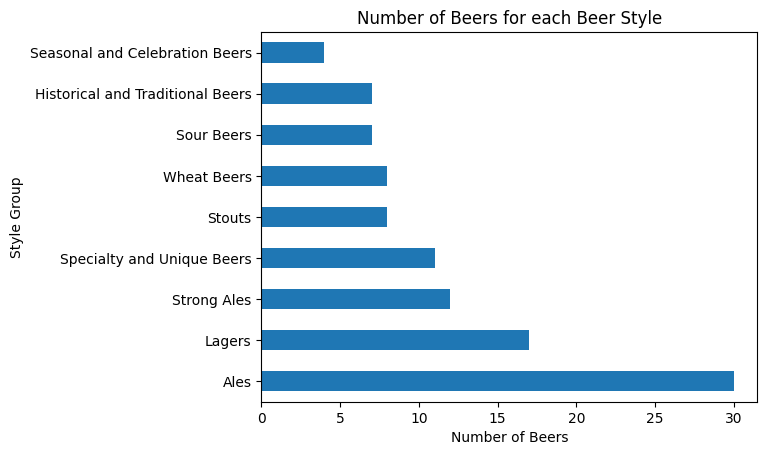

In [45]:
# Count the number of beers in each group and make a bar plot
beer_groups_df = pd.DataFrame.from_dict(beer_groups, orient='index', columns=['group'])
beer_groups_df['group'].value_counts().plot(kind='barh')
plt.title('Number of Beers for each Beer Style')
# plt.xlim(0, 18)
plt.xlabel('Number of Beers')
plt.ylabel('Style Group')
plt.show()

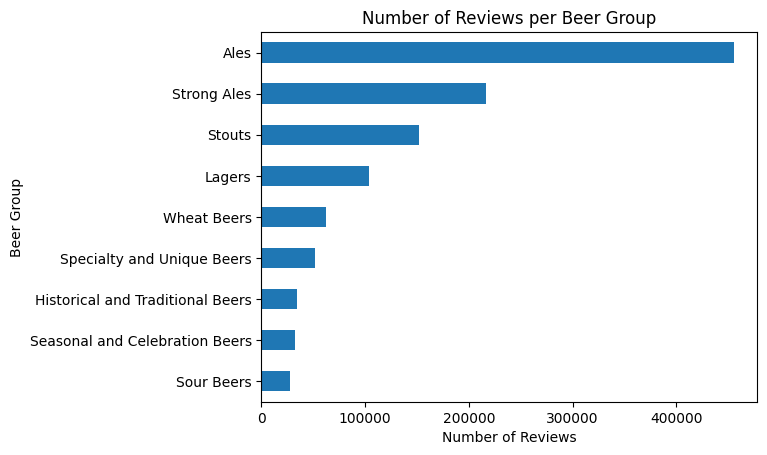

In [46]:
# add a column with beer style group
df['beer_group'] = df['style'].map(beer_groups)

# Plot the number of reviews per beer group
df['beer_group'].value_counts().sort_values().plot(kind='barh')
plt.xlabel('Number of Reviews')
plt.ylabel('Beer Group')
plt.title('Number of Reviews per Beer Group')
plt.show()

In [47]:
display(df.sample(3))

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,beer_id_avg_appearance,beer_id_avg_aroma,beer_id_avg_palate,beer_id_avg_taste,beer_id_avg_overall,beer_id_std,beer_id_std_appearance,beer_id_std_aroma,beer_id_std_palate,beer_id_std_taste,beer_id_std_overall,serving_type_rulebased,polarity,subjectivity,readability_score,user_filtered_nbr_reviews,beer_id_filtered_nbr_reviews,beer_id_filtered_avg,beer_id_filtered_std,beer_id_filtered_avg_appearance,beer_id_filtered_avg_aroma,beer_id_filtered_avg_palate,beer_id_filtered_avg_taste,beer_id_filtered_avg_overall,beer_id_filtered_std_appearance,beer_id_filtered_std_aroma,beer_id_filtered_std_palate,beer_id_filtered_std_taste,beer_id_filtered_std_overall,user_country,user_subregion,user_US_state,beer_group
1063353,656,202,Tripel,1229684400,kickinthechalice.267503,5.0,4.0,4.5,4.5,4.5,4.41,Let's go to Dendermonde.Poured from ...,4137,1335,4.24,8.4,824,823,1.226920e+09,"United States, Illinois",Belgium,5,4.218419,4.156392,4.160363,4.275719,4.241868,0.494940,0.461311,0.456763,0.495439,0.480605,0.494940,bottle,0.163049,0.529228,75.61,806,629,4.233831,0.399971,4.222973,4.169714,4.180843,4.275040,4.256359,0.454832,0.485573,0.517591,0.502055,0.507075,United States of America,Northern America,Illinois,Historical and Traditional Beers
493919,30970,262,American Double / Imperial IPA,1153044000,gcbrewingco.3241,4.5,4.0,4.0,4.0,3.0,3.83,The beer poured into the glass cryst...,2002,902,4.04,10.0,1556,1556,1.065780e+09,"United States, North Carolina","United States, New York",101,4.156493,3.989734,4.065760,4.080189,3.922863,0.559031,0.455442,0.477368,0.532203,0.548375,0.559031,bottle,0.248000,0.553667,71.55,1234,421,4.022708,0.434315,4.158551,3.963777,4.084323,4.076010,3.913895,0.462213,0.482146,0.542550,0.543506,0.578002,United States of America,Northern America,North Carolina,Strong Ales
1131024,46290,18371,Saison / Farmhouse Ale,1283335200,rhoadsrage.6920,4.5,4.5,4.0,4.0,4.0,4.15,(Served in a tulip glass) Bottled Ma...,1640,642,4.01,6.5,2786,2786,1.087985e+09,"United States, Illinois","United States, Massachusetts",33,4.042779,3.976845,3.995290,4.013344,4.054160,0.497251,0.427801,0.433414,0.462613,0.497654,0.497251,bottle,0.144044,0.384756,81.97,432,401,4.007257,0.385637,4.038030,3.978803,3.986908,4.003741,4.048005,0.450992,0.444606,0.466687,0.511112,0.525032,United States of America,Northern America,Illinois,Ales


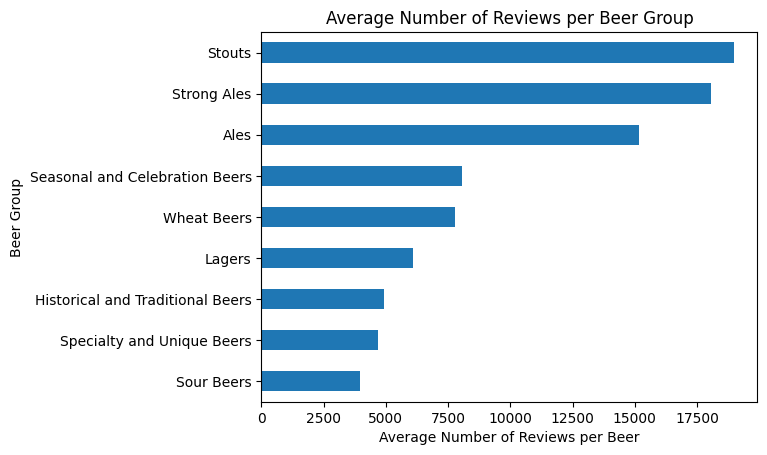

In [48]:
## pas sur de comprendre ce que montre ce plot ?

# Calculate the average number of reviews per beer group
average_reviews_per_group = df['beer_group'].value_counts().sort_values() / beer_groups_df['group'].value_counts()

# Plot the average number of reviews per beer group
average_reviews_per_group.sort_values().plot(kind='barh')
plt.xlabel('Average Number of Reviews per Beer')
plt.ylabel('Beer Group')
plt.title('Average Number of Reviews per Beer Group')
plt.show()

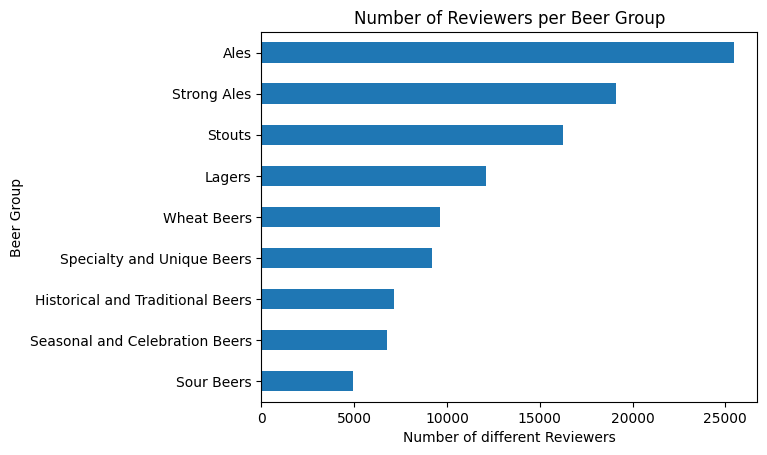

In [50]:
# Plot the number of reviewers per beer group
df.groupby('beer_group')['user_id'].nunique().sort_values().plot(kind='barh')
plt.xlabel('Number of different Reviewers')
plt.ylabel('Beer Group')
plt.title('Number of Reviewers per Beer Group')
plt.show()

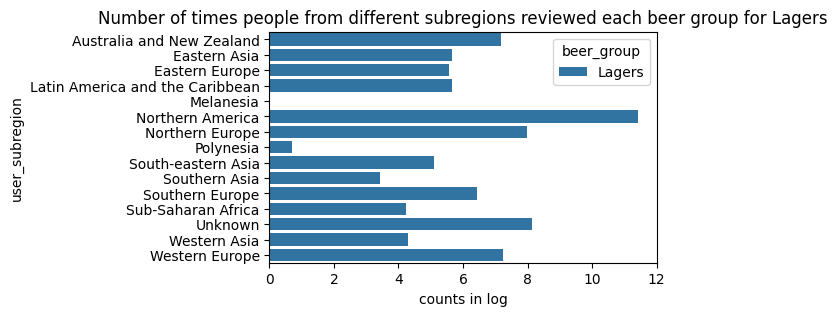

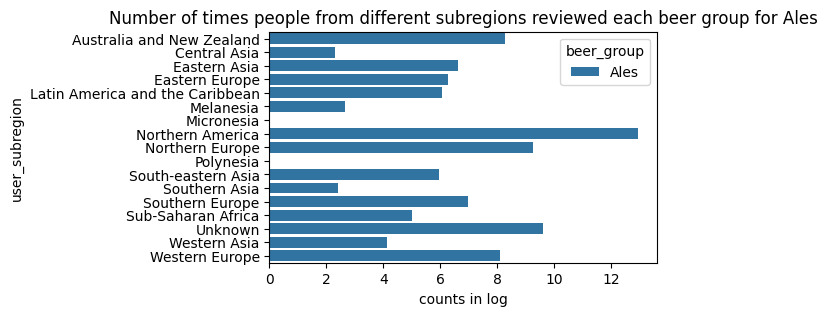

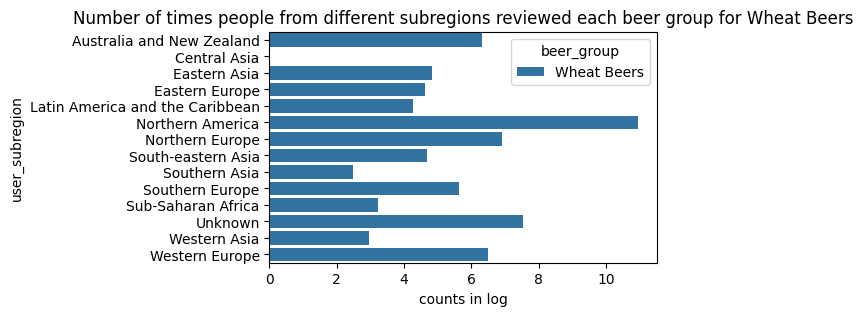

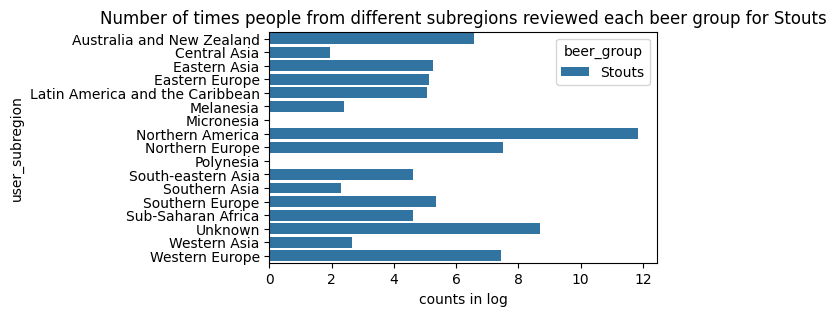

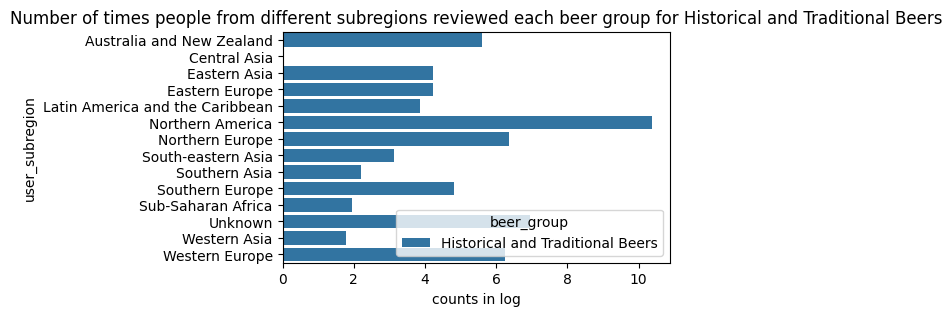

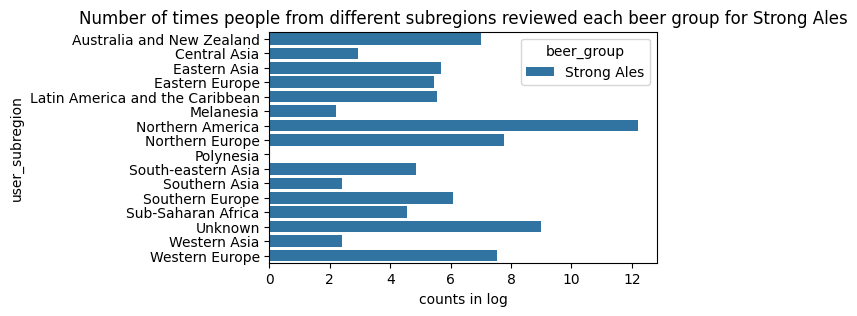

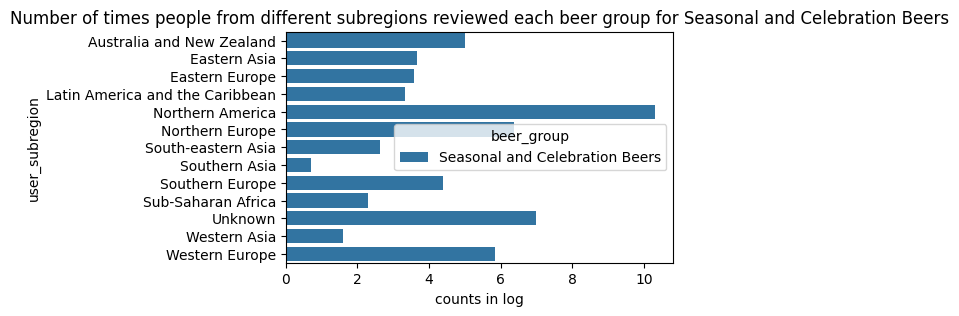

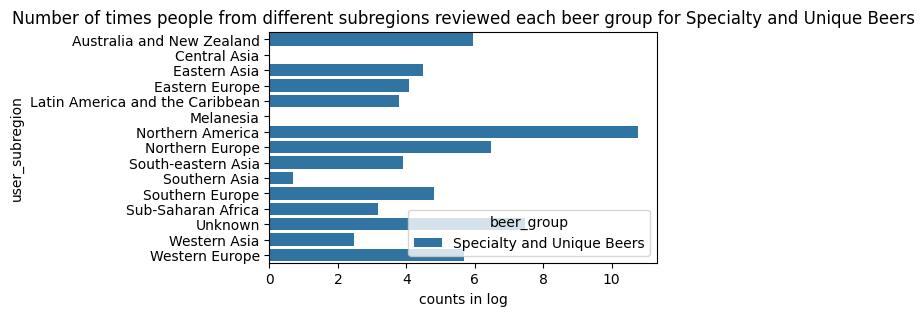

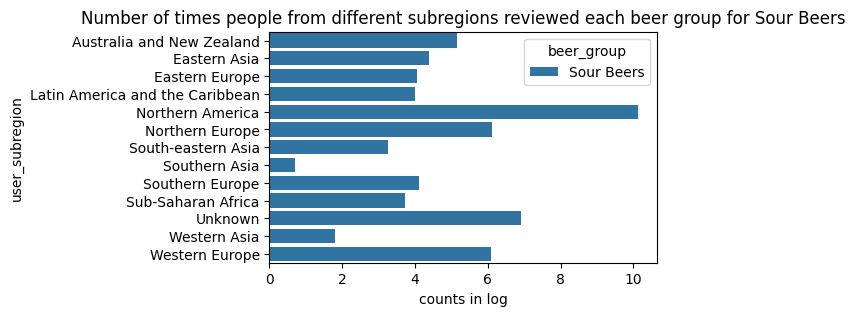

In [52]:
# Function to plot data for a given beer group
def plot_data(beer_group):
    # Filter the data for the given beer group
    grouped_data = df[df['beer_group'] == beer_group].groupby(['user_subregion', 'beer_group']).size().reset_index(name='counts')

    # Check if the grouped data is empty
    if grouped_data.empty:
        # Create a new dataframe with the desired structure, but with 0 counts
        grouped_data = pd.DataFrame({'user_subregion': df['user_subregion'].unique(),
                                     'beer_group': beer_group,
                                     'counts': 0})
    else:
        # Create a logarithmic transformation of the count data
        grouped_data['counts'] = np.log(grouped_data['counts'])

    # Create a horizontal bar chart for the selected rows
    plt.figure(figsize=(5, 3))
    sns.barplot(x='counts', y='user_subregion', hue='beer_group', data=grouped_data)
    plt.xlabel('counts in log')
    plt.title(f'Number of times people from different subregions reviewed each beer group for {beer_group}')
    plt.show()

# Loop through each beer group and plot the data
for beer_group in df['beer_group'].unique():
    try:
        plot_data(beer_group)
    except ValueError:
        print(f"No data for {beer_group}. Skipping.")

In [64]:
display(df.sample(5))
print('Shape of df:', df.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,beer_id_avg_appearance,beer_id_avg_aroma,beer_id_avg_palate,beer_id_avg_taste,beer_id_avg_overall,beer_id_std,beer_id_std_appearance,beer_id_std_aroma,beer_id_std_palate,beer_id_std_taste,beer_id_std_overall,serving_type_rulebased,polarity,subjectivity,readability_score,user_filtered_nbr_reviews,beer_id_filtered_nbr_reviews,beer_id_filtered_avg,beer_id_filtered_std,beer_id_filtered_avg_appearance,beer_id_filtered_avg_aroma,beer_id_filtered_avg_palate,beer_id_filtered_avg_taste,beer_id_filtered_avg_overall,beer_id_filtered_std_appearance,beer_id_filtered_std_aroma,beer_id_filtered_std_palate,beer_id_filtered_std_taste,beer_id_filtered_std_overall,user_country,user_subregion,user_US_state,beer_group
445795,103,35,American Pale Wheat Ale,1216634400,dodo2step.110880,4.0,3.5,3.5,3.5,4.0,3.63,P- on tap at Red Lobster...from note...,5541,1677,3.37,5.3,676,676,1.165576e+09,"United States, Pennsylvania","United States, Massachusetts",285,3.515878,3.310815,3.403685,3.335530,3.497603,0.710486,0.517574,0.563465,0.589466,0.654480,0.710486,draft,0.176455,0.507196,89.85,78,609,3.366831,0.540388,3.525862,3.312808,3.404762,3.313218,3.470854,0.541881,0.572872,0.606097,0.669859,0.726236,United States of America,Northern America,Pennsylvania,Wheat Beers
816981,3006,487,Hefeweizen,1169550000,procrastinator.109527,4.5,4.5,4.5,5.0,5.0,4.80,Enjoyed this exceptional brew on tap...,56,18,3.85,5.0,134,134,1.164884e+09,"United States, Florida","United States, Florida",82,3.819444,3.805556,3.861111,3.916667,3.944444,0.683608,0.617190,0.621641,0.447396,0.790569,0.683608,draft,0.212746,0.622285,78.14,131,6,3.490000,0.859023,3.583333,3.333333,3.583333,3.500000,3.583333,0.917424,0.816497,0.584523,1.095445,0.801041,United States of America,Northern America,Florida,Wheat Beers
619994,6815,2171,English Pale Ale,1301220000,swthomas55.215487,4.5,5.0,4.5,5.0,4.5,4.82,Had it on tap at the brewery in Temp...,278,87,3.61,4.9,50,49,1.209463e+09,"United States, Michigan","United States, Arizona",72,3.646552,3.577586,3.594828,3.589080,3.770115,0.589662,0.494963,0.572264,0.536788,0.558987,0.589662,draft,0.217121,0.459242,82.44,31,38,3.631053,0.622600,3.671053,3.664474,3.651316,3.552632,3.723684,0.609899,0.642725,0.632828,0.707484,0.692112,United States of America,Northern America,Michigan,Ales
310778,26500,3120,American Pale Ale (APA),1319104800,notchucknorris.463725,4.5,4.5,4.0,4.5,4.5,4.45,On tap at O'Brien'sA: Beautiful clea...,31,12,4.01,7.5,1870,1154,1.275041e+09,"United States, California","United States, California",113,4.125000,4.041667,4.000000,4.041667,4.125000,0.376889,0.376889,0.498102,0.639602,0.450168,0.376889,draft,0.203030,0.622727,84.47,295,6,3.996667,0.277248,3.916667,4.250000,3.583333,3.916667,4.083333,0.376386,0.273861,0.491596,0.376386,0.376386,United States of America,Northern America,California,Ales
780503,26788,11036,English Porter,1350381600,thedinger.621449,4.0,3.5,4.0,3.5,3.5,3.58,Poured from growler into a pint glas...,850,168,3.90,5.8,105,103,1.316686e+09,"United States, South Carolina","United States, North Carolina",130,4.032934,3.908683,3.814371,3.922156,3.920659,0.426079,0.383735,0.387453,0.453371,0.422364,0.426079,draft,0.214876,0.508560,89.14,94,94,3.931915,0.341626,4.050532,3.917553,3.808511,3.936170,3.962766,0.358424,0.367329,0.470109,0.429015,0.441401,United States of America,Northern America,South Carolina,Ales


Shape of df: (1136096, 55)


In [65]:
# Export complete dataset to parquet
df.to_parquet(dataset_path + 'BA_complete.parquet', index=False)

## 3. Check representation of dataset

In [66]:
# Read complete dataset 
df = pd.read_parquet(dataset_path + 'BA_complete.parquet')

In [67]:
display(df.sample(5))
print('Shape of df:', df.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,beer_id_avg_appearance,beer_id_avg_aroma,beer_id_avg_palate,beer_id_avg_taste,beer_id_avg_overall,beer_id_std,beer_id_std_appearance,beer_id_std_aroma,beer_id_std_palate,beer_id_std_taste,beer_id_std_overall,serving_type_rulebased,polarity,subjectivity,readability_score,user_filtered_nbr_reviews,beer_id_filtered_nbr_reviews,beer_id_filtered_avg,beer_id_filtered_std,beer_id_filtered_avg_appearance,beer_id_filtered_avg_aroma,beer_id_filtered_avg_palate,beer_id_filtered_avg_taste,beer_id_filtered_avg_overall,beer_id_filtered_std_appearance,beer_id_filtered_std_aroma,beer_id_filtered_std_palate,beer_id_filtered_std_taste,beer_id_filtered_std_overall,user_country,user_subregion,user_US_state,beer_group
275041,87151,2210,American Strong Ale,1366279200,obeermegreatone.407461,4.00,4.25,4.25,4.25,4.0,4.19,Poured from a bottle into my Chimay ...,1122,168,4.29,13.0,703,465,1.261480e+09,"United States, California","United States, California",207,4.130303,4.269697,4.219697,4.356061,4.265152,0.411067,0.389054,0.391397,0.426618,0.442718,0.411067,bottle,0.058456,0.413271,77.43,170,81,4.266543,0.370645,4.064815,4.228395,4.240741,4.348765,4.216049,0.396819,0.403496,0.433814,0.463814,0.443271,United States of America,Northern America,California,Strong Ales
100761,47490,19218,Braggot,1315130400,jsanford.430116,3.50,5.00,2.50,2.00,2.5,2.96,750 C&amp;C bottle split with some f...,42,28,3.80,10.1,1476,1063,1.266664e+09,"United States, Georgia",Denmark,2,3.750000,3.901786,3.794643,3.803571,3.651786,0.643123,0.372678,0.442736,0.573543,0.566655,0.643123,bottle,0.132353,0.480392,84.98,678,17,3.757059,0.356349,3.705882,3.838235,3.750000,3.794118,3.602941,0.397603,0.507300,0.515388,0.587868,0.424437,United States of America,Northern America,Georgia,Historical and Traditional Beers
433854,74390,35,American Stout,1322823600,bucbasil.134775,4.00,3.50,3.50,3.50,3.5,3.53,Poured from the 12 oz bottle into a ...,1017,333,3.74,5.8,632,578,1.177063e+09,"United States, South Carolina","United States, Massachusetts",285,3.971471,3.786036,3.645646,3.768769,3.768769,0.439726,0.421036,0.506561,0.547616,0.519775,0.439726,bottle,0.216667,0.606667,84.78,525,116,3.745345,0.390466,3.937500,3.814655,3.577586,3.715517,3.747845,0.419465,0.486917,0.517534,0.495520,0.434261,United States of America,Northern America,South Carolina,Stouts
666923,23052,9797,Irish Red Ale,1393153200,tone77.332060,4.25,3.25,3.50,3.50,3.5,3.49,A big thanks to the legendary woodyc...,134,37,3.38,5.5,3489,3489,1.242814e+09,"United States, Pennsylvania","United States, Pennsylvania",122,3.703125,3.281250,3.429688,3.406250,3.359375,0.538582,0.423301,0.545325,0.586248,0.674268,0.538582,can,0.373333,0.643333,95.37,3426,17,3.305294,0.580411,3.735294,3.147059,3.367647,3.308824,3.323529,0.454754,0.655856,0.638098,0.731701,0.597944,United States of America,Northern America,Pennsylvania,Ales
911104,44048,9897,Saison / Farmhouse Ale,1311847200,thorpe429.243272,4.00,3.50,4.00,4.00,4.0,3.88,On tap at Churchkey. Served in a sni...,517,196,4.05,4.5,5368,4254,1.219054e+09,"United States, Illinois","United States, Michigan",125,4.013021,3.967448,3.972656,4.071615,4.139323,0.475640,0.500484,0.427210,0.478840,0.453046,0.475640,draft,0.359048,0.585000,95.27,2583,111,4.044505,0.298903,3.986486,3.959459,3.952703,4.083333,4.130631,0.539189,0.389552,0.442762,0.387787,0.416761,United States of America,Northern America,Illinois,Ales


Shape of df: (1136096, 55)


In [53]:
# load the filtered dataset
filtered_df = df.copy(deep=True)
# filter per beer id and keep only the columns witg reviews, avg, std, or the words appearance, aroma, palate, taste, overall at the end
#list of columns to keep
columns_beer = [
    'serving_type_rulebased',
    'beer_nbr_reviews',
    'beer_id_filtered_nbr_reviews',
    'avg',
    'beer_id_avg_appearance',
    'beer_id_avg_aroma',
    'beer_id_avg_palate',
    'beer_id_avg_taste',
    'beer_id_avg_overall',
    'beer_id_std',
    'beer_id_std_appearance',
    'beer_id_std_aroma',
    'beer_id_std_palate',
    'beer_id_std_taste',
    'beer_id_std_overall',
    'beer_id_filtered_nbr_reviews',
    'beer_id_filtered_avg',
    'beer_id_filtered_std',
    'beer_id_filtered_avg_appearance',
    'beer_id_filtered_avg_aroma',
    'beer_id_filtered_avg_palate',
    'beer_id_filtered_avg_taste',
    'beer_id_filtered_avg_overall',
    'beer_id_filtered_std_appearance',
    'beer_id_filtered_std_aroma',
    'beer_id_filtered_std_palate',
    'beer_id_filtered_std_taste',
    'beer_id_filtered_std_overall'
]

columns_user = [
    'user_nbr_reviews',
    'user_filtered_nbr_reviews'
]

columns_user = ['user_nbr_reviews', 'user_filtered_nbr_reviews']

# Group by beer_id and user_id and perform aggregation
filtered_df_beer = filtered_df.groupby('beer_id').agg({col: 'first' for col in columns_beer})
filtered_df_user = filtered_df.groupby('user_id').agg({col: 'first' for col in columns_user})

In [54]:
display(filtered_df_beer)

,serving_type_rulebased,beer_nbr_reviews,beer_id_filtered_nbr_reviews,avg,beer_id_avg_appearance,beer_id_avg_aroma,beer_id_avg_palate,beer_id_avg_taste,beer_id_avg_overall,beer_id_std,beer_id_std_appearance,beer_id_std_aroma,beer_id_std_palate,beer_id_std_taste,beer_id_std_overall,beer_id_filtered_avg,beer_id_filtered_std,beer_id_filtered_avg_appearance,beer_id_filtered_avg_aroma,beer_id_filtered_avg_palate,beer_id_filtered_avg_taste,beer_id_filtered_avg_overall,beer_id_filtered_std_appearance,beer_id_filtered_std_aroma,beer_id_filtered_std_palate,beer_id_filtered_std_taste,beer_id_filtered_std_overall
beer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,bottle,10,6,3.64,3.950000,3.800000,3.700000,3.450000,3.700000,0.674949,0.643342,0.586894,0.752773,0.831665,0.674949,3.530000,0.540629,3.666667,3.583333,3.833333,3.333333,3.666667,0.605530,0.584523,0.258199,0.752773,0.516398
5,bottle,543,179,3.40,3.524674,3.239758,3.342644,3.379423,3.525605,0.629218,0.551432,0.589188,0.624931,0.626498,0.629218,3.390223,0.526773,3.555866,3.255587,3.356145,3.377095,3.543296,0.560604,0.607164,0.588314,0.631216,0.629236
6,bottle,1019,328,3.64,3.843287,3.537019,3.537759,3.653258,3.697187,0.585922,0.449730,0.542863,0.550551,0.538438,0.585922,3.598720,0.469943,3.850610,3.467988,3.506098,3.638720,3.644817,0.441293,0.554834,0.559838,0.591901,0.636843
7,draft,811,262,3.20,3.297188,3.212500,3.158437,3.133750,3.278125,0.774065,0.639154,0.698089,0.677024,0.727124,0.774065,3.213588,0.590684,3.307252,3.205153,3.189885,3.166031,3.300573,0.629393,0.691452,0.628553,0.700377,0.756245
8,draft,72,32,3.27,3.277778,3.055556,3.291667,3.215278,3.569444,0.857057,0.610293,0.647615,0.659439,0.701238,0.857057,3.268438,0.604697,3.265625,3.140625,3.250000,3.187500,3.593750,0.647382,0.650488,0.683917,0.704250,0.827331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293255,draft,1,1,3.83,4.000000,4.000000,3.750000,3.750000,3.750000,NaN,NaN,NaN,NaN,NaN,NaN,3.830000,NaN,4.000000,4.000000,3.750000,3.750000,3.750000,NaN,NaN,NaN,NaN,NaN
293261,draft,1,1,3.67,3.750000,3.500000,3.500000,3.750000,3.750000,NaN,NaN,NaN,NaN,NaN,NaN,3.670000,NaN,3.750000,3.500000,3.500000,3.750000,3.750000,NaN,NaN,NaN,NaN,NaN
293264,draft,1,1,4.23,4.250000,4.250000,4.000000,4.250000,4.250000,NaN,NaN,NaN,NaN,NaN,NaN,4.230000,NaN,4.250000,4.250000,4.000000,4.250000,4.250000,NaN,NaN,NaN,NaN,NaN


In [55]:
display(filtered_df_user)

,user_nbr_reviews,user_filtered_nbr_reviews
user_id,,
--dom--.709199,53,32
--weezl--.789708,3,2
-blast-tyrant-.1105240,1,1
-mk-.763762,8,1
-rick.912339,194,52
...,...,...
zythophile.1101219,184,146
zythus.301538,8,4
zz427.1113802,2,2


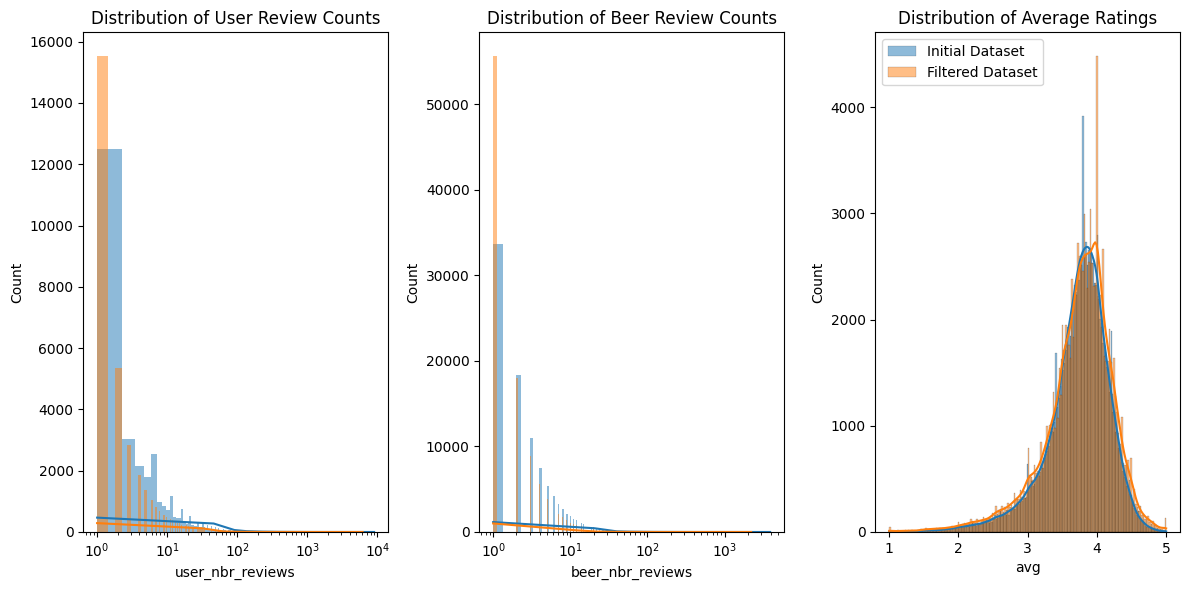

In [56]:
# Check the distribution of key columns to see if they are similar
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))

# Distribution of User Review Counts
axes[0].set_title('Distribution of User Review Counts')
sns.histplot(filtered_df_user['user_nbr_reviews'], kde=True, ax=axes[0], label='Initial Dataset')
sns.histplot(filtered_df_user['user_filtered_nbr_reviews'], kde=True, ax=axes[0], label='Filtered Dataset')
#axes[0].set_ylim([1e0, 25000])
axes[0].set_xscale('log')
#axes[0].set_yscale('log')

# Distribution of Beer Review Counts
axes[1].set_title('Distribution of Beer Review Counts')
sns.histplot(filtered_df_beer['beer_nbr_reviews'], kde=True, ax=axes[1], label='Initial Dataset')
sns.histplot(filtered_df_beer['beer_id_filtered_nbr_reviews'], kde=True, ax=axes[1], label='Filtered Dataset')
#axes[1].set_ylim([1e0, 2000000])
axes[1].set_xscale('log')
#axes[1].set_yscale('log')

# Distribution of Average Ratings
axes[2].set_title('Distribution of Average Ratings')
sns.histplot(filtered_df_beer['avg'], kde=True, ax=axes[2], label='Initial Dataset')
sns.histplot(filtered_df_beer['beer_id_filtered_avg'], kde=True, ax=axes[2], label='Filtered Dataset')

plt.tight_layout()
plt.legend()
plt.show()

In [57]:
# compare similar infos
t_stat, p_value = ttest_ind(filtered_df_beer['avg'], filtered_df_beer['beer_id_filtered_avg'])
print("\nT-Test Results: Average Rating")
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

filtered_df_beer_std= filtered_df_beer[filtered_df_beer['beer_id_filtered_std'].notna()]
t_stat, p_value = ttest_ind(filtered_df_beer_std['beer_id_std'], filtered_df_beer_std['beer_id_filtered_std'])
print("\nT-Test Results: Standard Deviation of Rating")
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

t_stat, p_value = ttest_ind(filtered_df_user['user_nbr_reviews'], filtered_df_user['user_filtered_nbr_reviews'])
print("\nT-Test Results: Number of user reviews ")
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

t_stat, p_value = ttest_ind(filtered_df_beer['beer_nbr_reviews'], filtered_df_beer['beer_id_filtered_nbr_reviews'])
print("\nT-Test Results: Number of beer reviews ")
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")


T-Test Results: Average Rating
T-Statistic: -1.1290189612971835, P-Value: 0.25889100720134045

T-Test Results: Standard Deviation of Rating
T-Statistic: 70.13576535069848, P-Value: 0.0

T-Test Results: Number of user reviews 
T-Statistic: 22.72002916444651, P-Value: 6.630524293749952e-114

T-Test Results: Number of beer reviews 
T-Statistic: 35.128718174246195, P-Value: 1.2723976178213726e-269


In [58]:
# compare similar infos on appearance, aroma, palate, taste and overall
t_stat, p_value = ttest_ind(filtered_df_beer['beer_id_avg_appearance'], filtered_df_beer['beer_id_filtered_avg_appearance'])
print("\nT-Test Results: Average Appearance")
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

t_stat, p_value = ttest_ind(filtered_df_beer['beer_id_avg_aroma'], filtered_df_beer['beer_id_filtered_avg_aroma'])
print("\nT-Test Results: Average Aroma")
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

t_stat, p_value = ttest_ind(filtered_df_beer['beer_id_avg_palate'], filtered_df_beer['beer_id_filtered_avg_palate'])
print("\nT-Test Results: Average Palate")
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

t_stat, p_value = ttest_ind(filtered_df_beer['beer_id_avg_taste'], filtered_df_beer['beer_id_filtered_avg_taste'])
print("\nT-Test Results: Average Taste")
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

t_stat, p_value = ttest_ind(filtered_df_beer['beer_id_avg_overall'], filtered_df_beer['beer_id_filtered_avg_overall'])
print("\nT-Test Results: Average Overall")
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")



T-Test Results: Average Appearance
T-Statistic: 2.2299607038644496, P-Value: 0.025751008610487257

T-Test Results: Average Aroma
T-Statistic: 2.645897849906301, P-Value: 0.008147993251071638

T-Test Results: Average Palate
T-Statistic: 2.09720244289561, P-Value: 0.035976742282585475

T-Test Results: Average Taste
T-Statistic: 2.646002453337517, P-Value: 0.008145474166164025

T-Test Results: Average Overall
T-Statistic: 3.2162636474305244, P-Value: 0.001298893288587714


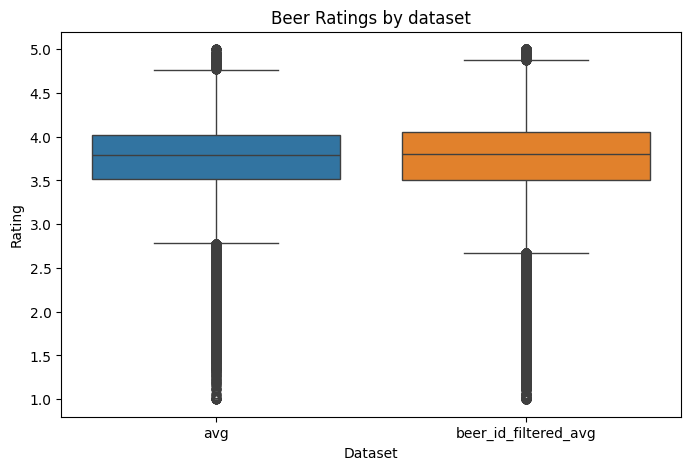

In [59]:
# box plot of the average rating per beer "avg" and the computed average rating per beer "beer_avg_computed" from df_filtered_beer
plt.figure(figsize=(8, 5))
sns.boxplot(data=filtered_df_beer[['avg', 'beer_id_filtered_avg']])
plt.title('Beer Ratings by dataset')
plt.xlabel('Dataset')
plt.ylabel('Rating')
plt.show()

<blockquote>

From these tests, we can see that the dataset is still representative of the initial one. The average rating of a beer is still the same, and the distribution of the ratings is also similar. We can therefore continue our analysis on this dataset.

However, as expected, we lost a lot of reviews, therefore the amount of reviews per beer is statistically significant from the initial amount of reviews per beer. 

We were not sure, if the same conclusion could be drawn for the amount of reviews per user, since some users might always give the serving style or never. At the end, we see that the distribution is still similar, but the amount of reviews per user is statistically significant from the initial amount of reviews per user. 

</blockquote>


## 4. Visualization 📊

> Visualize the distribution of serving type between beer groups and world regions.

In [2]:
df = pd.read_parquet(dataset_path + 'BA_complete.parquet')

### 4.1 Beer groups and serving style 🍻

In [38]:
df.sample(3)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,beer_id_avg_appearance,beer_id_avg_aroma,beer_id_avg_palate,beer_id_avg_taste,beer_id_avg_overall,beer_id_std,beer_id_std_appearance,beer_id_std_aroma,beer_id_std_palate,beer_id_std_taste,beer_id_std_overall,serving_type_rulebased,polarity,subjectivity,readability_score,user_filtered_nbr_reviews,beer_id_filtered_nbr_reviews,beer_id_filtered_avg,beer_id_filtered_std,beer_id_filtered_avg_appearance,beer_id_filtered_avg_aroma,beer_id_filtered_avg_palate,beer_id_filtered_avg_taste,beer_id_filtered_avg_overall,beer_id_filtered_std_appearance,beer_id_filtered_std_aroma,beer_id_filtered_std_palate,beer_id_filtered_std_taste,beer_id_filtered_std_overall,user_country,user_subregion,user_US_state,beer_group
10513,52204,16315,American Double / Imperial Stout,1306231200,dmsohyea.555311,3.00,3.5,2.0,3.00,2.50,2.92,"Poured from a 12 oz bottle, served i...",773,279,3.87,18.2,313,92,1.295521e+09,"United States, California",Scotland,330,3.903080,3.923007,3.790761,3.840580,3.618659,0.829132,0.504416,0.657617,0.683185,0.721074,0.829132,bottle,0.068619,0.560924,77.74,88,141,3.803333,0.595845,3.909574,3.934397,3.765957,3.815603,3.606383,0.535588,0.610653,0.688692,0.717539,0.810772,United States of America,Northern America,California,Stouts
866921,52211,14879,Pumpkin Ale,1354273200,caddybuyer.221961,3.50,3.5,2.5,4.00,3.50,3.60,2012 release. Poured from a chilled ...,749,267,3.80,8.4,282,282,1.211537e+09,"United States, New Jersey","United States, Ohio",104,3.488636,3.945076,3.642992,3.803977,3.729167,0.578892,0.592542,0.511107,0.558939,0.579820,0.578892,bottle,0.245460,0.521494,84.17,199,130,3.781308,0.482624,3.411538,4.003846,3.607692,3.786538,3.700000,0.615420,0.503846,0.594662,0.590716,0.611105,United States of America,Northern America,New Jersey,Specialty and Unique Beers
1031093,145616,30356,American Double / Imperial IPA,1463220000,greesyfizeek.721957,3.75,4.0,4.0,4.25,4.25,4.14,On tap at the Tap and Mallet in Roch...,486,122,4.13,8.0,3656,3307,1.362568e+09,"United States, New York","United States, Oklahoma",129,4.094262,4.116803,4.096311,4.182377,4.139344,0.321491,0.356938,0.388609,0.400731,0.374879,0.321491,draft,0.182179,0.445385,83.25,2652,53,4.157170,0.339578,4.122642,4.165094,4.084906,4.183962,4.127358,0.372177,0.376418,0.451875,0.413565,0.359027,United States of America,Northern America,New York,Strong Ales


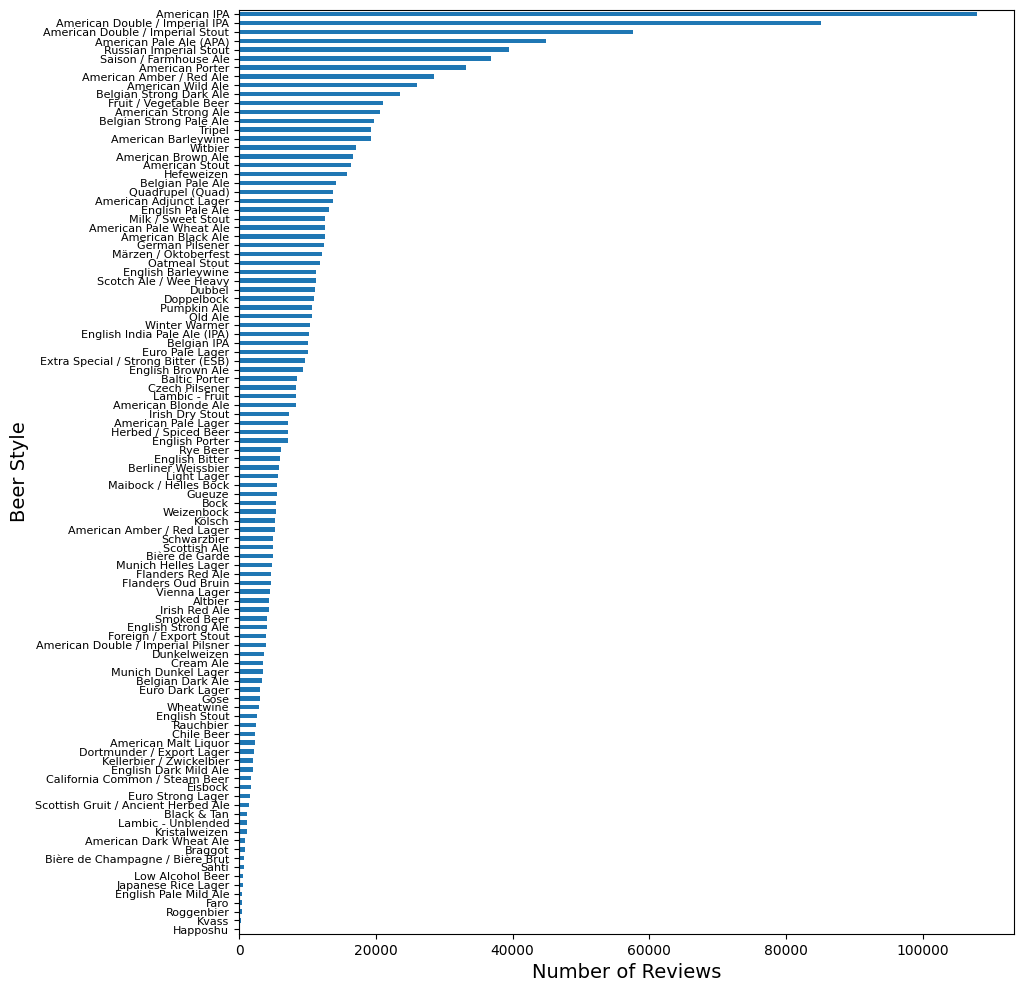

In [50]:
# Show the number of reviews per beer style
plt.figure(figsize=(10, 12))
df['style'].value_counts().sort_values().plot(kind='barh')
plt.ylabel('Beer Style', fontsize=14)
plt.xlabel('Number of Reviews', fontsize=14)
plt.yticks(fontsize=8)
plt.show()

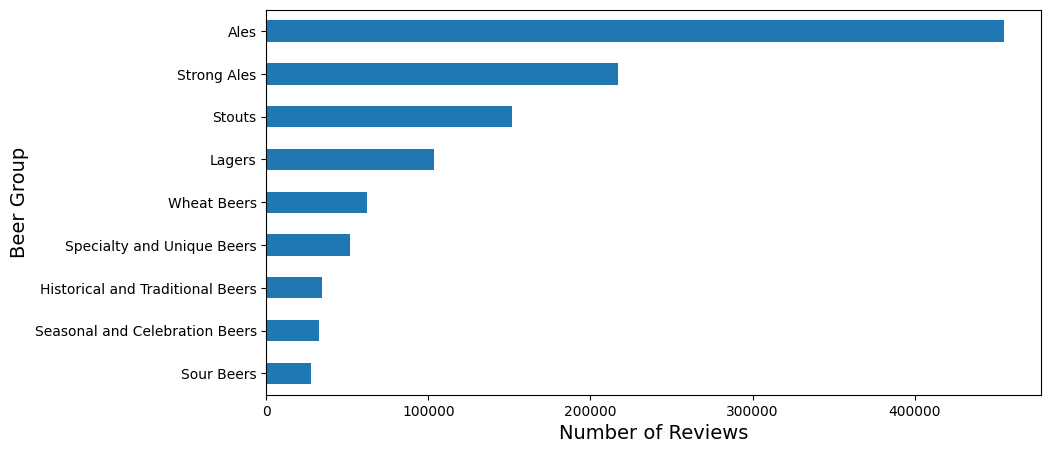

In [52]:
# Show the nubmer of reviews per beer group
plt.figure(figsize=(10, 5))
df['beer_group'].value_counts().sort_values().plot(kind='barh')
plt.ylabel('Beer Group', fontsize=14)
plt.xlabel('Number of Reviews', fontsize=14)
plt.show()

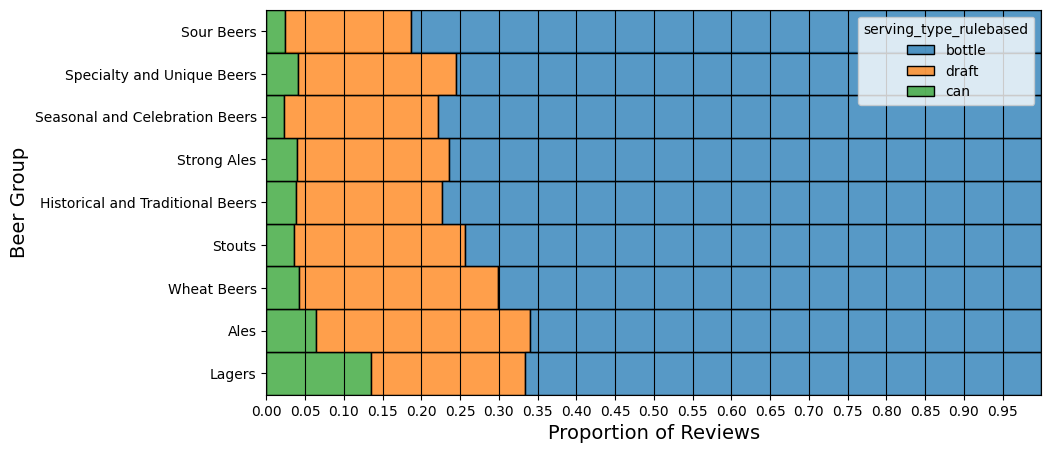

In [75]:
# Show the distribution of serving types among beer groups normalized 
plt.figure(figsize=(10, 5))
sns.histplot(data=df, y='beer_group', hue='serving_type_rulebased', multiple='fill')
plt.xlabel('Proportion of Reviews', fontsize=14)
plt.ylabel('Beer Group', fontsize=14)
# add vertical lines
plt.grid(axis='x', linewidth=0.8, color='black')
plt.xticks(np.arange(0, 1, 0.05))
plt.gca().invert_yaxis()
plt.show()

In [67]:
from scipy.stats import chi2_contingency

# perform a statistical test to see if the serving type is independent of the beer group
# create a contingency table
contingency_table = pd.crosstab(df['beer_group'], df['serving_type_rulebased'])
contingency_table

# perform the chi2 test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
print('Chi2 Stat:', chi2_stat)
print('P-Value:', p_value)

if p_value < 0.05:
    print('The serving type is dependent on the beer group.')
else:
    print('The serving type is independent of the beer group.')


Chi2 Stat: 26627.809491593456
P-Value: 0.0
The serving type is dependent on the beer group.


In [65]:
def cramers_v(contingency_table):
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    phi2 = chi2/n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Compute Cramér's V
cramers_v_value = cramers_v(contingency_table)
print('Cramér\'s V:', cramers_v_value)

# the strength of the association between the two variables is weak (to moderate)

Cramér's V: 0.10822187943107953


> The serving type is dependent on the beer group. We can for example see that around 10% of Lagers are served in a can but that this value is only 2-3% for seasonal beers. After computing Cramer's V, we can see however see that the correlation is not very strong, as the value is only 0.108. 

### 4.2 World region and serving style 🌍

In [76]:
display(df.sample(3))
print('Shape of df:', df.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,beer_id_avg_appearance,beer_id_avg_aroma,beer_id_avg_palate,beer_id_avg_taste,beer_id_avg_overall,beer_id_std,beer_id_std_appearance,beer_id_std_aroma,beer_id_std_palate,beer_id_std_taste,beer_id_std_overall,serving_type_rulebased,polarity,subjectivity,readability_score,user_filtered_nbr_reviews,beer_id_filtered_nbr_reviews,beer_id_filtered_avg,beer_id_filtered_std,beer_id_filtered_avg_appearance,beer_id_filtered_avg_aroma,beer_id_filtered_avg_palate,beer_id_filtered_avg_taste,beer_id_filtered_avg_overall,beer_id_filtered_std_appearance,beer_id_filtered_std_aroma,beer_id_filtered_std_palate,beer_id_filtered_std_taste,beer_id_filtered_std_overall,user_country,user_subregion,user_US_state,beer_group
1124167,31941,7773,American Double / Imperial IPA,1223373600,kraken.197893,4.0,4.0,4.0,4.5,3.5,4.10,Reviewed from notes.Poured from a 22...,263,229,4.01,9.0,262,262,1.203851e+09,"United States, Maryland","United States, Pennsylvania",20,4.052402,3.912664,3.958515,4.015284,4.057860,0.489118,0.415549,0.524627,0.474600,0.483030,0.489118,bottle,0.192685,0.560370,78.75,248,118,3.991610,0.387000,4.021186,3.885593,3.957627,4.016949,4.076271,0.383384,0.516443,0.426556,0.506084,0.496256,United States of America,Northern America,Maryland,Strong Ales
1090241,7286,1534,Belgian Strong Dark Ale,1228129200,corby112.268461,5.0,3.5,4.0,4.5,4.0,4.14,Served on-tap at Monk's Cafe in Phil...,869,499,3.97,10.5,2855,2853,1.227092e+09,"United States, Pennsylvania",Belgium,38,4.042339,4.055444,4.030746,4.042339,3.922883,0.676052,0.502742,0.548368,0.578388,0.639185,0.676052,draft,0.018452,0.459821,84.88,1051,252,4.012262,0.585440,4.047619,4.039683,4.001984,4.035714,3.925595,0.511048,0.575403,0.641754,0.717742,0.732138,United States of America,Northern America,Pennsylvania,Strong Ales
863181,45558,73,Saison / Farmhouse Ale,1243418400,alleykatking.257816,4.0,4.0,3.5,3.5,4.0,3.75,Poured from a 12 oz pour.A- Poured i...,236,177,3.34,6.2,1166,1166,1.224065e+09,"United States, Indiana","United States, Ohio",171,3.765537,3.388418,3.576271,3.320621,3.333333,0.930339,0.485703,0.814844,0.651573,0.889865,0.930339,bottle,0.216667,0.583951,97.20,1070,82,3.518780,0.674629,3.841463,3.487805,3.719512,3.469512,3.457317,0.477119,0.757577,0.567089,0.836467,0.879117,United States of America,Northern America,Indiana,Ales


Shape of df: (1136096, 55)


In [87]:
# remove reviews with unknown location
df = df[df['user_country'] != 'Unknown'].copy(deep=True)
display(df.sample(3))
print('Shape of df:', df.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,beer_id_avg_appearance,beer_id_avg_aroma,beer_id_avg_palate,beer_id_avg_taste,beer_id_avg_overall,beer_id_std,beer_id_std_appearance,beer_id_std_aroma,beer_id_std_palate,beer_id_std_taste,beer_id_std_overall,serving_type_rulebased,polarity,subjectivity,readability_score,user_filtered_nbr_reviews,beer_id_filtered_nbr_reviews,beer_id_filtered_avg,beer_id_filtered_std,beer_id_filtered_avg_appearance,beer_id_filtered_avg_aroma,beer_id_filtered_avg_palate,beer_id_filtered_avg_taste,beer_id_filtered_avg_overall,beer_id_filtered_std_appearance,beer_id_filtered_std_aroma,beer_id_filtered_std_palate,beer_id_filtered_std_taste,beer_id_filtered_std_overall,user_country,user_subregion,user_US_state,beer_group
722596,184,141,American Brown Ale,1228215600,sholland119.38560,4.0,4.0,4.0,4.0,4.0,4.00,On tap at Memphis Taproom.A-A clear ...,2686,969,3.91,6.7,1264,1046,1.126174e+09,"United States, Pennsylvania","United States, New Hampshire",182,3.814189,3.765333,3.840437,3.975572,4.003119,0.480353,0.457023,0.460270,0.490553,0.464170,0.480353,draft,0.235000,0.688333,87.52,447,356,3.895618,0.389487,3.806882,3.747191,3.794944,3.976124,3.988062,0.429250,0.466474,0.516027,0.479281,0.486832,United States of America,Northern America,Pennsylvania,Ales
446011,103,35,American Pale Wheat Ale,1051437600,tavernjef.1706,4.0,4.0,3.5,3.5,4.0,3.75,On Tap: Color is a pale dark yellow-...,5541,1677,3.37,5.3,2038,2037,1.047035e+09,"United States, Minnesota","United States, Massachusetts",285,3.515878,3.310815,3.403685,3.335530,3.497603,0.710486,0.517574,0.563465,0.589466,0.654480,0.710486,draft,0.213125,0.539750,84.61,695,609,3.366831,0.540388,3.525862,3.312808,3.404762,3.313218,3.470854,0.541881,0.572872,0.606097,0.669859,0.726236,United States of America,Northern America,Minnesota,Wheat Beers
707847,1262,423,English Porter,1347876000,rfbenavi80.438173,4.0,4.0,4.0,3.5,4.0,3.80,Bottle best by 12-1-12Bottle poured ...,1134,527,3.87,6.0,361,165,1.268651e+09,"United States, Missouri","United States, Missouri",140,4.119545,3.780835,3.780835,3.970114,3.981499,0.459908,0.445656,0.469480,0.478256,0.477819,0.459908,bottle,0.011090,0.534774,85.49,152,196,3.957653,0.357975,4.159439,3.818878,3.801020,4.020408,4.015306,0.428653,0.487380,0.450725,0.483939,0.428648,United States of America,Northern America,Missouri,Ales


Shape of df: (1097262, 55)


#### 4.2.1 World region

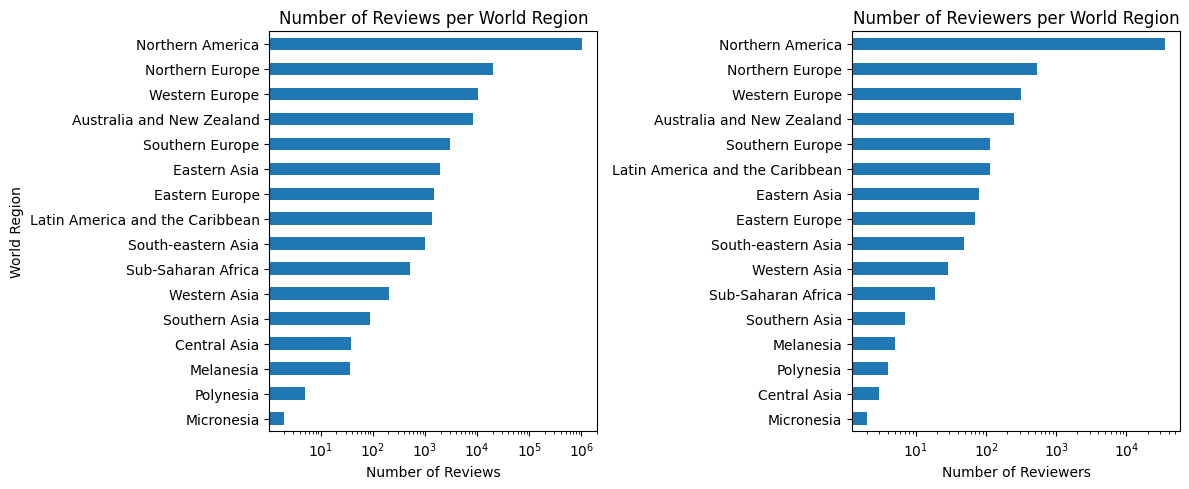

In [88]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the number of reviews per world region
df.user_subregion.value_counts().sort_values().plot(kind='barh', ax=ax1)
ax1.set_xlabel('Number of Reviews')
ax1.set_ylabel('World Region')
ax1.set_title('Number of Reviews per World Region')
ax1.set_xscale('log')

# Plot the number of reviewers per world region
df.groupby('user_subregion')['user_id'].nunique().sort_values().plot(kind='barh', ax=ax2)
ax2.set_xlabel('Number of Reviewers')
ax2.set_ylabel('')  # Hide the y-label
ax2.set_title('Number of Reviewers per World Region')
ax2.set_xscale('log')

plt.tight_layout()
plt.show()

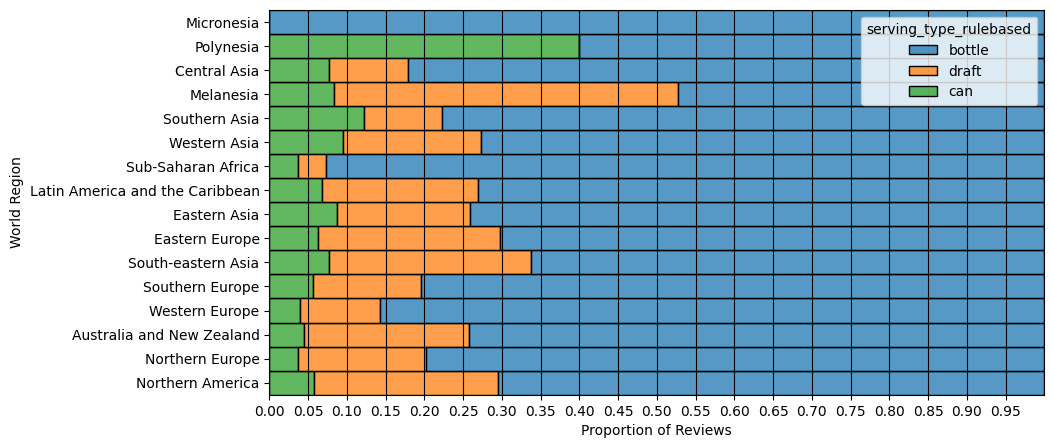

In [89]:
# show the distribution of serving types among world regions normalized
plt.figure(figsize=(10, 5))
sns.histplot(data=df, y='user_subregion', hue='serving_type_rulebased', multiple='fill')
plt.xlabel('Proportion of Reviews')
plt.ylabel('World Region')
# add vertical lines
plt.grid(axis='x', linewidth=0.8, color='black')
plt.xticks(np.arange(0, 1, 0.05))
plt.gca().invert_yaxis()
plt.show()

In [95]:
# perform a statistical test to see if the serving type is independent of the world region
# create a contingency table
contingency_table = pd.crosstab(df['user_subregion'], df['serving_type_rulebased'])
display(contingency_table)

# perform the chi2 test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
print('Chi2 Stat:', chi2_stat)
print('P-Value:', p_value)

if p_value < 0.05:
    print('The serving type is dependent on the world region.')
else:
    print('The serving type is independent of the world region.')

serving_type_rulebased,bottle,can,draft
user_subregion,,,
Australia and New Zealand,6343,382,1824
Central Asia,32,3,4
Eastern Asia,1420,167,329
Eastern Europe,1067,96,355
Latin America and the Caribbean,1003,94,276
Melanesia,17,3,16
Micronesia,2,0,0
Northern America,738117,60372,249358
Northern Europe,16482,769,3420


Chi2 Stat: 2497.519880963564
P-Value: 0.0
The serving type is dependent on the world region.


In [92]:
# compute the strength of the association between the two variables
cramers_v_value = cramers_v(contingency_table)
print('Cramér\'s V:', cramers_v_value)

Cramér's V: 0.033532818295758535


> The serving type is also dependant of the world region. After computing Cramer's V, we can see that the correlation is very weak (0.03).

#### 4.2.2 US states 🇺🇸

In [96]:
# keep only reviews with user_US_state not null
df = df[df['user_US_state'].notna()].copy(deep=True)
display(df.sample(3))
print('Shape of df:', df.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,beer_id_avg_appearance,beer_id_avg_aroma,beer_id_avg_palate,beer_id_avg_taste,beer_id_avg_overall,beer_id_std,beer_id_std_appearance,beer_id_std_aroma,beer_id_std_palate,beer_id_std_taste,beer_id_std_overall,serving_type_rulebased,polarity,subjectivity,readability_score,user_filtered_nbr_reviews,beer_id_filtered_nbr_reviews,beer_id_filtered_avg,beer_id_filtered_std,beer_id_filtered_avg_appearance,beer_id_filtered_avg_aroma,beer_id_filtered_avg_palate,beer_id_filtered_avg_taste,beer_id_filtered_avg_overall,beer_id_filtered_std_appearance,beer_id_filtered_std_aroma,beer_id_filtered_std_palate,beer_id_filtered_std_taste,beer_id_filtered_std_overall,user_country,user_subregion,user_US_state,beer_group
200277,3470,782,American Pale Ale (APA),1160992800,terrabyte.82548,3.0,1.5,3.0,2.5,2.5,2.34,Pours somewhat dark yellow/amber col...,36,34,3.26,5.5,241,241,1.149674e+09,"United States, Wisconsin","United States, Wisconsin",56,3.602941,3.338235,3.264706,3.250000,3.220588,0.827475,0.422464,0.693264,0.642383,0.741109,0.827475,bottle,0.083623,0.481481,75.81,57,9,2.922222,0.709256,3.500000,2.944444,3.166667,2.833333,2.777778,0.433013,0.845741,0.661438,0.707107,1.034139,United States of America,Northern America,Wisconsin,Ales
238539,68781,632,American IPA,1304762400,jethrodium.441768,4.0,3.5,3.5,3.5,3.5,3.53,On tap at the brewpub. Pours a sligh...,3,2,3.62,4.8,252,252,1.269515e+09,"United States, California","United States, California",120,3.500000,3.500000,3.750000,3.500000,3.500000,0.000000,0.707107,0.000000,0.353553,0.000000,0.000000,draft,0.172222,0.493333,74.08,242,2,3.525000,0.007071,3.500000,3.500000,3.750000,3.500000,3.500000,0.707107,0.000000,0.353553,0.000000,0.000000,United States of America,Northern America,California,Ales
917506,40671,335,American Double / Imperial Stout,1330858800,barnzy78.224763,4.5,4.0,4.5,4.0,4.0,4.08,"22oz bottle, pours opaque black into...",977,381,4.04,10.8,2439,1372,1.212401e+09,"United States, Illinois","United States, Michigan",225,3.989474,3.994737,4.048026,4.104605,3.986842,0.576151,0.521839,0.457247,0.546181,0.552111,0.576151,bottle,0.189444,0.563667,77.13,1044,206,4.056505,0.433668,3.992718,3.998786,4.094660,4.112864,4.010922,0.559787,0.433011,0.509204,0.550780,0.580844,United States of America,Northern America,Illinois,Stouts


Shape of df: (983516, 55)


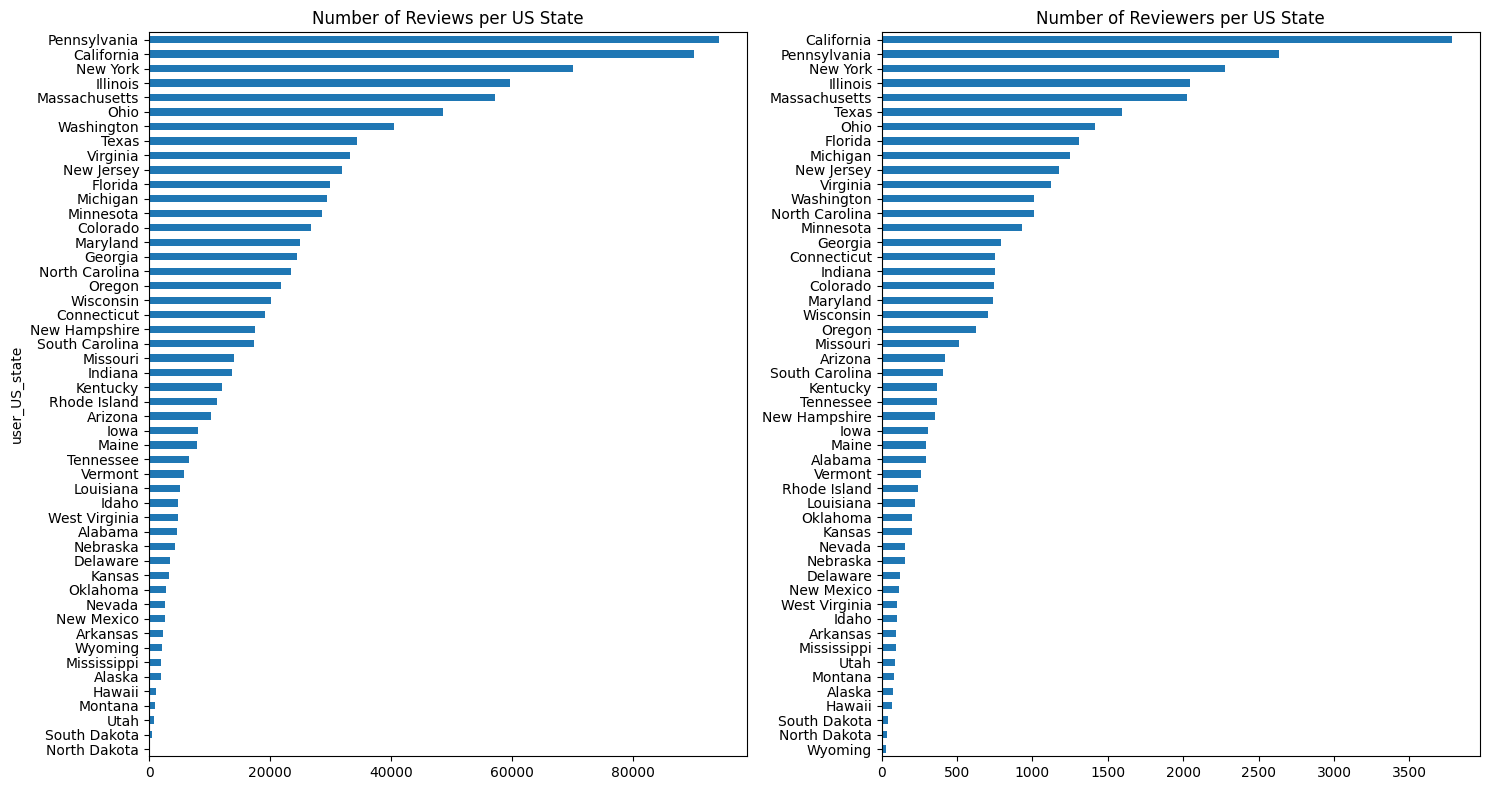

In [97]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Number of reviews per US state
df.user_US_state.value_counts().sort_values().plot(kind='barh', ax=ax1)
ax1.set_title('Number of Reviews per US State')

# Number of reviewers per US state
df.groupby('user_US_state')['user_id'].nunique().sort_values().plot(kind='barh', ax=ax2)
ax2.set_title('Number of Reviewers per US State')
ax2.set_ylabel('')  # Hide the y-label

plt.tight_layout()
plt.show()

In [98]:
# perform a statistical test to see if the serving type is independent of the US_state
# create a contingency table
contingency_table = pd.crosstab(df['user_US_state'], df['serving_type_rulebased'])
display(contingency_table)

# perform the chi2 test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
print('Chi2 Stat:', chi2_stat)
print('P-Value:', p_value)

if p_value < 0.05:
    print('The serving type is dependent on the US state.')
else:
    print('The serving type is independent of the US state.')
    
# compute the strength of the association between the two variables
cramers_v_value = cramers_v(contingency_table)
print('Cramér\'s V:', cramers_v_value)

serving_type_rulebased,bottle,can,draft
user_US_state,,,
Alabama,3463,244,836
Alaska,1225,89,670
Arizona,7849,449,2017
Arkansas,1715,148,475
California,60456,3486,26164
Colorado,18933,1745,6110
Connecticut,12720,1319,5106
Delaware,2668,231,559
Florida,22089,1694,6204


Chi2 Stat: 14482.6525967669
P-Value: 0.0
The serving type is dependent on the US state.
Cramér's V: 0.08551541671148646


> We can see that the serving type is also dependant of the US state. After computing Cramer's V, we can see that the correlation is also weak (0.09).

In [6]:
# show boxplot and histograms of ratings for bottle, can and draft
# plt.figure(figsize=(10, 6))
# plt.subplot(121)
# sns.boxplot(data=df, hue='serving_type_rulebased', y='rating')
# plt.legend(loc='upper left')
# plt.subplot(122)
# sns.histplot(data=df, hue='serving_type_rulebased', x='rating', kde=True, bins=20)
# plt.tight_layout()
# plt.show()

## 5. Statistical Analysis 📈

### 5.1 Measure the impact of each aspect on rating 📏
> First draft analysis to look which aspect has more impact on the rating. We will continue this analysis in P3.

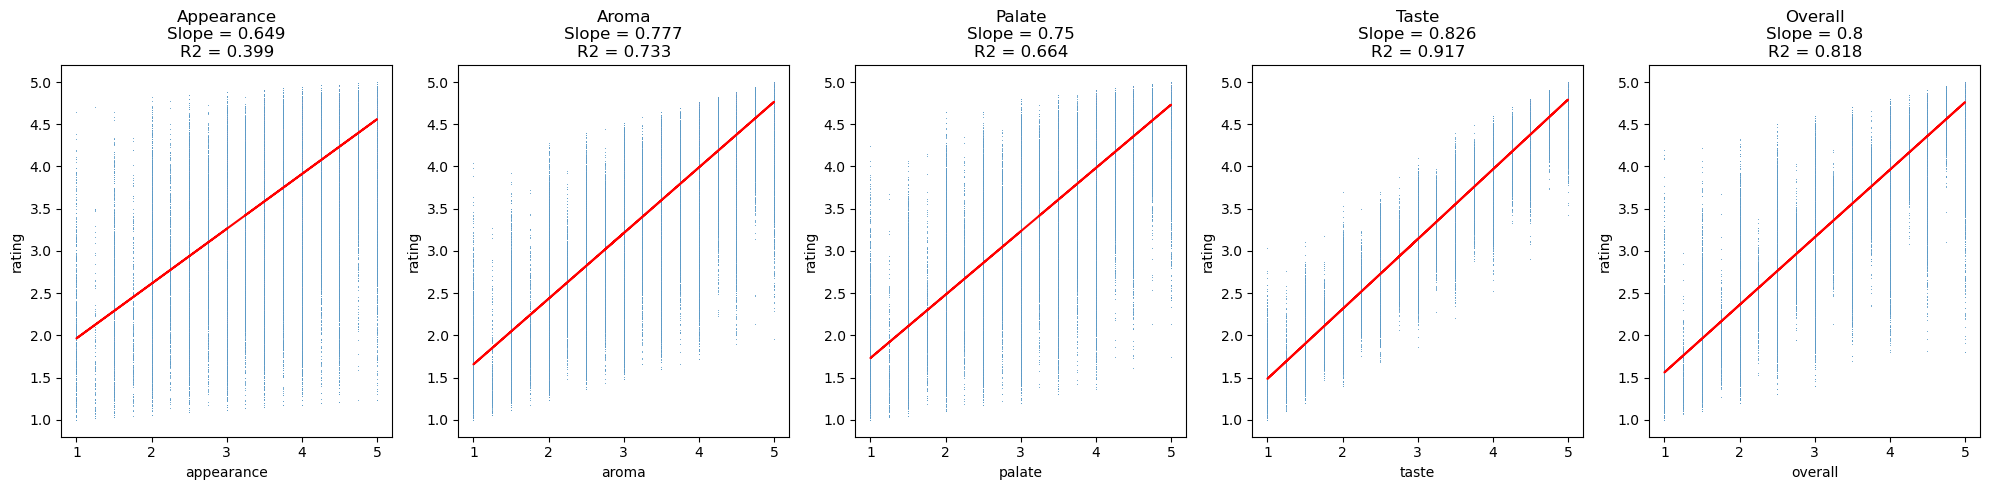

In [100]:
# fit a linear regression line to the data for all 5 aspects
reg1 = LinearRegression().fit(df[['appearance']], df['rating'])
reg2 = LinearRegression().fit(df[['aroma']], df['rating'])
reg3 = LinearRegression().fit(df[['palate']], df['rating'])
reg4 = LinearRegression().fit(df[['taste']], df['rating'])
reg5 = LinearRegression().fit(df[['overall']], df['rating'])

# create subplots for all 5 aspects
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

# plot the data and regression line for each aspect
sns.scatterplot(data=df, x='appearance', y='rating', s=0.5, ax=axs[0])
axs[0].plot(df[['appearance']], reg1.predict(df[['appearance']]), color='red')
axs[0].set_title('Appearance\nSlope = ' + str(round(reg1.coef_[0], 3)) + '\nR2 = ' + str(round(reg1.score(df[['appearance']], df['rating']), 3)))

sns.scatterplot(data=df, x='aroma', y='rating', s=0.5, ax=axs[1])
axs[1].plot(df[['aroma']], reg2.predict(df[['aroma']]), color='red')
axs[1].set_title('Aroma\nSlope = ' + str(round(reg2.coef_[0], 3)) + '\nR2 = ' + str(round(reg2.score(df[['aroma']], df['rating']), 3)))

sns.scatterplot(data=df, x='palate', y='rating', s=0.5, ax=axs[2])
axs[2].plot(df[['palate']], reg3.predict(df[['palate']]), color='red')
axs[2].set_title('Palate\nSlope = ' + str(round(reg3.coef_[0], 3)) + '\nR2 = ' + str(round(reg3.score(df[['palate']], df['rating']), 3)))

sns.scatterplot(data=df, x='taste', y='rating', s=0.5, ax=axs[3])
axs[3].plot(df[['taste']], reg4.predict(df[['taste']]), color='red')
axs[3].set_title('Taste\nSlope = ' + str(round(reg4.coef_[0], 3)) + '\nR2 = ' + str(round(reg4.score(df[['taste']], df['rating']), 3)))

sns.scatterplot(data=df, x='overall', y='rating', s=0.5, ax=axs[4])
axs[4].plot(df[['overall']], reg5.predict(df[['overall']]), color='red')
axs[4].set_title('Overall\nSlope = ' + str(round(reg5.coef_[0], 3)) + '\nR2 = ' + str(round(reg5.score(df[['overall']], df['rating']), 3)))

plt.tight_layout()
plt.show()

# should still add confidence intervals

> It seems like Taste as the biggest impact on the rating while appearance has the least impact.

### 5.2 Hypothesis testing on the new labels

In [60]:
def do_ttest(type1: str, type2: str, category: str) -> None:
    """
    Perform a t-test on the two samples of the given category for the given serving types.
    
    Parameters:
    - type1 (str): The first serving type.
    - type2 (str): The second serving type.
    - category (str): The category to perform the t-test on.

    """
    ttest = ttest_ind(df[df['serving_type_rulebased'] == type1][category],df[df['serving_type_rulebased'] == type2][category])
    if ttest[1] > 0.05:
        print('The p-value is high (' + str(ttest[1]) + '), so we cannot reject the null hypothesis that the two samples have the same average')
    else:
        print('The p-value is very low (' + str(ttest[1]) + '), so we can reject the null hypothesis that the two samples have the same average')

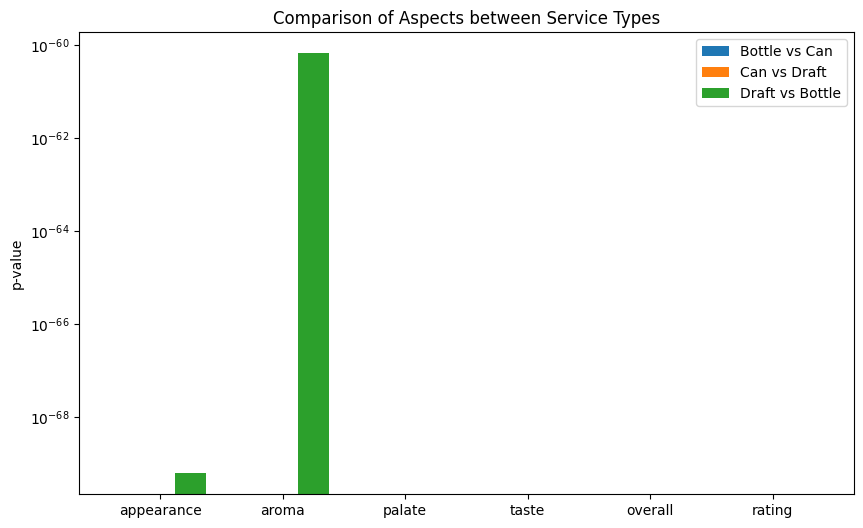

In [61]:
# compare each aspect between all three serving types

# define the columns to compare
columns = ['appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']

# create an empty matrix to store the p-values
p_values = np.zeros((len(columns), 3))

# perform the t-test and store the p-values in the matrix
for i in range(len(columns)):
    ttest1 = ttest_ind(df[df['serving_type_rulebased'] == 'bottle'][columns[i]], df[df['serving_type_rulebased'] == 'can'][columns[i]])
    ttest2 = ttest_ind(df[df['serving_type_rulebased'] == 'can'][columns[i]], df[df['serving_type_rulebased'] == 'draft'][columns[i]])
    ttest3 = ttest_ind(df[df['serving_type_rulebased'] == 'draft'][columns[i]], df[df['serving_type_rulebased'] == 'bottle'][columns[i]])
    p_values[i][0] = ttest1[1]
    p_values[i][1] = ttest2[1]
    p_values[i][2] = ttest3[1]

# create the grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(columns))
width = 0.25
rects1 = ax.bar(x - width, p_values[:,0], width, label='Bottle vs Can')
rects2 = ax.bar(x, p_values[:,1], width, label='Can vs Draft')
rects3 = ax.bar(x + width, p_values[:,2], width, label='Draft vs Bottle')
ax.set_xticks(x)
ax.set_yscale('log')
ax.set_xticklabels(columns)
ax.set_ylabel('p-value')
ax.set_title('Comparison of Aspects between Service Types')
ax.legend()
plt.show()

> All the p-values are below 0.05, so we can reject the null hypothesis and conclude that there is a significant difference between the groups.

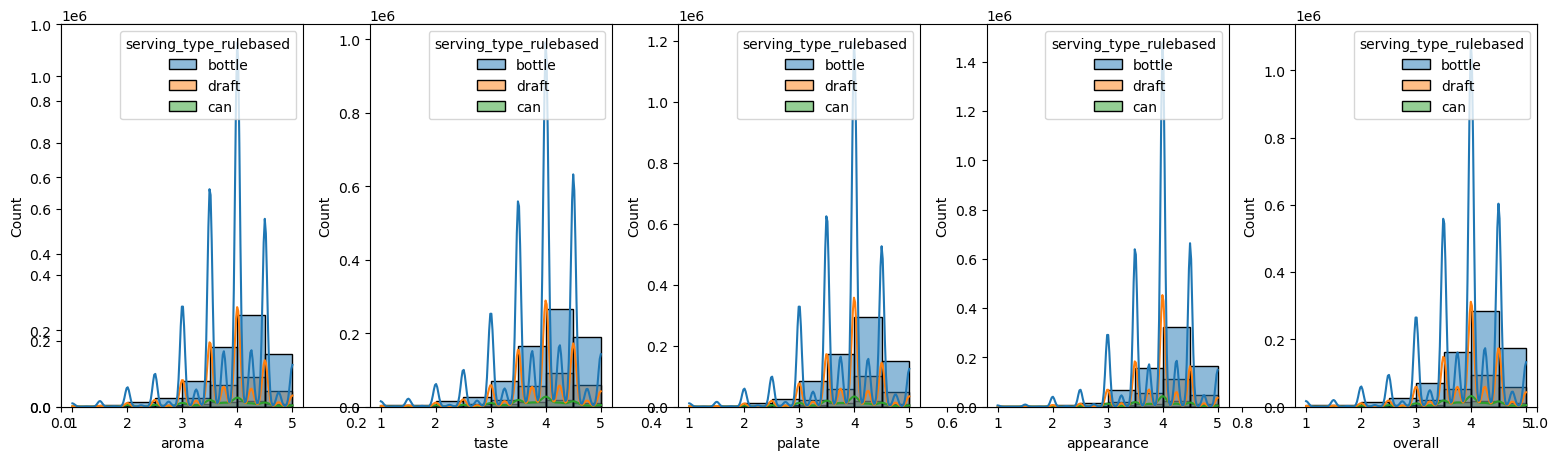

In [103]:
# Task 7.3 : analysis of the serving style on the ratings and tasting palette
# Histogram of the ratings for each serving type
plt.subplots(figsize=(16, 5))
plt.subplot(151)
sns.histplot(data=df, hue='serving_type_rulebased', x='aroma', kde=True, bins=8)
plt.subplot(152)
sns.histplot(data=df, hue='serving_type_rulebased', x='taste', kde=True, bins=8)
plt.subplot(153)
sns.histplot(data=df, hue='serving_type_rulebased', x='palate', kde=True, bins=8)
plt.subplot(154)
sns.histplot(data=df, hue='serving_type_rulebased', x='appearance', kde=True, bins=8)
plt.subplot(155)
sns.histplot(data=df, hue='serving_type_rulebased', x='overall', kde=True, bins=8)
plt.tight_layout()
plt.show()

### 5.3 Comparison of the ratings between the serving styles for specific beer ids

In [ ]:
df.columns

Index(['beer_id', 'brewery_id', 'style', 'date', 'user_id', 'appearance',
       'aroma', 'palate', 'taste', 'overall', 'rating', 'text',
       'beer_nbr_ratings', 'beer_nbr_reviews', 'avg', 'abv',
       'user_nbr_ratings', 'user_nbr_reviews', 'user_joined', 'user_location',
       'brewery_location', 'brewery_nbr_beers', 'beer_id_avg_appearance',
       'beer_id_avg_aroma', 'beer_id_avg_palate', 'beer_id_avg_taste',
       'beer_id_avg_overall', 'beer_id_std', 'beer_id_std_appearance',
       'beer_id_std_aroma', 'beer_id_std_palate', 'beer_id_std_taste',
       'beer_id_std_overall', 'serving_type_rulebased', 'polarity',
       'subjectivity', 'readability_score', 'user_filtered_nbr_reviews',
       'beer_id_filtered_nbr_reviews', 'beer_id_filtered_avg',
       'beer_id_filtered_std', 'beer_id_filtered_avg_appearance',
       'beer_id_filtered_avg_aroma', 'beer_id_filtered_avg_palate',
       'beer_id_filtered_avg_taste', 'beer_id_filtered_avg_overall',
       'beer_id_filtered_std

In [ ]:
df_match = df.groupby(['beer_id', 'serving_type_rulebased']).size().unstack().reset_index()
df_match.columns = ['beer_id', 'bottle', 'can', 'draft']
df_match.fillna(0, inplace=True)
df_match[['bottle', 'can', 'draft']] = df_match[['bottle', 'can', 'draft']].astype(int)

print('Shape of df_match:', df_match.shape)

# keep only beer that have at least n reviews for each serving type
n = 3
df_match = df_match[(df_match['bottle'] >= n) & (df_match['can'] >= n) & (df_match['draft'] >= n)].copy(deep=True)


display(df_match.sample(5))
print('Shape of df_match:', df_match.shape)

Shape of df_match: (115525, 4)


,beer_id,bottle,can,draft
2178,2779,143,40,17
34957,57747,622,3,64
102537,232360,31,18,8
1276,1585,431,5,11
34157,56551,43,3,6


Shape of df_match: (1145, 4)


In [ ]:
from scipy.stats import f_oneway

# Filter the DataFrame for the specified beer IDs
filtered_df = df[df['beer_id'].isin(df_match['beer_id'])]

In [ ]:
aspects = ['aroma', 'appearance', 'palate', 'taste', 'overall']
above_threshold = []
below_threshold = []

for aspect in aspects:
    above = 0
    below = 0
    
    for beer_id in tqdm(set(filtered_df['beer_id'])):
        # Filter the DataFrame for the specified beer ID
        filtered_df_specific = filtered_df[filtered_df['beer_id'] == beer_id]

        # Perform the one-way ANOVA test
        result = f_oneway(filtered_df_specific[filtered_df_specific['serving_type_rulebased'] == 'bottle'][aspect],
                          filtered_df_specific[filtered_df_specific['serving_type_rulebased'] == 'can'][aspect],
                          filtered_df_specific[filtered_df_specific['serving_type_rulebased'] == 'draft'][aspect])

        if result.pvalue < 0.05:
            above += 1
        else:
            below += 1
    
    above_threshold.append(above)
    below_threshold.append(below)
    print(f'The percentage of beers where the {aspect} is significantly different between serving types is {round(above / (above + below) * 100, 2)}%.\n')


100%|██████████| 1145/1145 [00:00<00:00, 1232.59it/s]


The percentage of beers where the aroma is significantly different between serving types is 10.57%.



100%|██████████| 1145/1145 [00:00<00:00, 1548.48it/s]


The percentage of beers where the appearance is significantly different between serving types is 13.19%.



100%|██████████| 1145/1145 [00:00<00:00, 1830.29it/s]


The percentage of beers where the palate is significantly different between serving types is 10.22%.



100%|██████████| 1145/1145 [00:00<00:00, 1789.24it/s]


The percentage of beers where the taste is significantly different between serving types is 14.5%.



100%|██████████| 1145/1145 [00:00<00:00, 1791.98it/s]

The percentage of beers where the overall is significantly different between serving types is 10.92%.

